# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
# Load required libraries
import pandas as pd
import numpy as np
import pandas.tseries
import matplotlib
import matplotlib.pyplot as plt

import plotly.express as px
from pyzipcode import ZipCodeDatabase
import folium

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX


import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose

from sklearn import metrics

pd.set_option('display.max_rows', 20)
pd.options.display.max_columns=300

In [2]:
!ls ../../Data

austin_area_zip_codes.geojson
zillow_data.csv


In [3]:
data = pd.read_csv('../../Data/zillow_data.csv')
data.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06   1996-07   1996-08   1996-09  \
0         1  334200.0  335400.0  336500.0  337600.0  338500.0  339500.0   
1         2  235700.0  236900.0  236700.0  235400.0  233300.0  230600.0   
2         3  210400.0  212200.0  212200.0  210700.0  208300.0  205500.0   
3         4  498100.0  500900.0  503100.0  504600.0  505500.0  505700.0   
4         5   77300.0   77300.0   77300.0   77300.0   77400.0   77500.0   

    1996-10   1996-11   1996-12   1997-01   1997-02   1997-03   1997-04  \
0  340400.0  341300.0  342600.0  344400.0  345700.0  346700.0  347800.0   
1  227300.0  223400.0  219600.0  215800.0  211100.0  205700.0  200900.0   
2  202500.0  199800.0  198300.0  197300.0  195400.0  193000.0  191800.0   
3  505300.0  504200.0  503600.0  503400.0  502200.0  500000.0  497900.0   
4   77600.0   77700.0   77700.0   77800.0   77900.0   77900.0   77800.0   

    1997-05   1997-06   1997-07   1997-08   1997-09   1997-10   1997-11  \
0  349000.0  350400.0  352000.0  353900.0  356200.0  358800.0  361800.0   
1  196800.0  193600.0  191400.0  190400.0  190800.0  192700.0  196000.0   
2  191800.0  193000.0  195200.0  198400.0  202800.0  208000.0  213800.0   
3  496300.0  495200.0  494700.0  494900.0  496200.0  498600.0  502000.0   
4   77800.0   77800.0   77800.0   77800.0   77900.0   78100.0   78200.0   

    1997-12   1998-01   1998-02   1998-03   1998-04   1998-05   1998-06  \
0  365700.0  370200.0  374700.0  378900.0  383500.0  388300.0  393300.0   
1  201300.0  207400.0  212200.0  214600.0  215100.0  213400.0  210200.0   
2  220700.0  227500.0  231800.0  233400.0  233900.0  233500.0  233300.0   
3  507600.0  514900.0  522200.0  529500.0  537900.0  546900.0  556400.0   
4   78400.0   78600.0   78800.0   79000.0   79100.0   79200.0   79300.0   

    1998-07   1998-08   1998-09   1998-10   1998-11   1998-12   1999-01  \
0  398500.0  403800.0  409100.0  414600.0  420100.0  426200.0  432600.0   
1  206100.0  202100.0  198800.0  196100.0  194100.0  193400.0  193400.0   
2  234300.0  237400.0  242800.0  250200.0  258600.0  268000.0  277000.0   
3  566100.0  575600.0  584800.0  593500.0  601600.0  610100.0  618600.0   
4   79300.0   79300.0   79400.0   79500.0   79500.0   79600.0   79700.0   

    1999-02   1999-03   1999-04   1999-05   1999-06   1999-07   1999-08  \
0  438600.0  444200.0  450000.0  455900.0  462100.0  468500.0  475300.0   
1  193100.0  192700.0  193000.0  193700.0  194800.0  196100.0  197800.0   
2  283600.0  288500.0  293900.0  299200.0  304300.0  308600.0  311400.0   
3  625600.0  631100.0  636600.0  642100.0  647600.0  653300.0  659300.0   
4   79900.0   80100.0   80300.0   80600.0   80900.0   81200.0   81400.0   

    1999-09   1999-10   1999-11   1999-12   2000-01   2000-02   2000-03  \
0  482500.0  490200.0  498200.0  507200.0  516800.0  526300.0  535300.0   
1  199700.0  201900.0  204500.0  207800.0  211500.0  214900.0  217800.0   
2  312300.0  311900.0  311100.0  311700.0  313500.0  315000.0  316700.0   
3  665800.0  672900.0  680500.0  689600.0  699700.0  709300.0  718300.0   
4   81700.0   82100.0   82400.0   82600.0   82800.0   82900.0   83000.0   

    2000-04   2000-05   2000-06   2000-07   2000-08   2000-09   2000-10  \
0  544500.0  553500.0  562400.0  571200.0  579800.0  588100.0  596300.0   
1  221100.0  224100.0  226700.0  228200.0  228500.0  227200.0  224900.0   
2  319800.0  323700.0  327500.0  329900.0  329800.0  326400.0  320100.0   
3  727600.0  737100.0  746600.0  756200.0  765800.0  775100.0  784400.0   
4   83000.0   82900.0   82800.0 

In [4]:
texas_data= data[data['State'] == 'TX']
texas_data

RegionID  RegionName           City State              Metro  \
1         90668       75070       McKinney    TX  Dallas-Fort Worth   
2         91982       77494           Katy    TX            Houston   
4         93144       79936        El Paso    TX            El Paso   
5         91733       77084        Houston    TX            Houston   
8         91940       77449           Katy    TX            Houston   
...         ...         ...            ...   ...                ...   
14372     91640       76941        Mertzon    TX         San Angelo   
14472     92897       79313          Anton    TX          Levelland   
14492     92921       79355         Plains    TX                NaN   
14599     92929       79366  Ransom Canyon    TX            Lubbock   
14695     91948       77457      Matagorda    TX           Bay City   

      CountyName  SizeRank   1996-04   1996-05   1996-06   1996-07   1996-08  \
1         Collin         2  235700.0  236900.0  236700.0  235400.0  233300.0   
2         Harris         3  210400.0  212200.0  212200.0  210700.0  208300.0   
4        El Paso         5   77300.0   77300.0   77300.0   77300.0   77400.0   
5         Harris         6   95000.0   95200.0   95400.0   95700.0   95900.0   
8         Harris         9   95400.0   95600.0   95800.0   96100.0   96400.0   
...          ...       ...       ...       ...       ...       ...       ...   
14372      Irion     14373       NaN       NaN       NaN       NaN       NaN   
14472    Hockley     14473       NaN       NaN       NaN       NaN       NaN   
14492     Yoakum     14493       NaN       NaN       NaN       NaN       NaN   
14599    Lubbock     14600  134500.0  134500.0  134400.0  134400.0  134300.0   
14695  Matagorda     14696   90700.0   91000.0   91200.0   91500.0   91800.0   

        1996-09   1996-10   1996-11   1996-12   1997-01   1997-02   1997-03  \
1      230600.0  227300.0  223400.0  219600.0  215800.0  211100.0  205700.0   
2      205500.0  202500.0  199800.0  198300.0  197300.0  195400.0  193000.0   
4       77500.0   77600.0   77700.0   77700.0   77800.0   77900.0   77900.0   
5       96100.0   96200.0   96100.0   96000.0   95800.0   95500.0   95300.0   
8       96700.0   96800.0   96800.0   96700.0   96600.0   96400.0   96200.0   
...         ...       ...       ...       ...       ...       ...       ...   
14372       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
14472       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
14492       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
14599  134200.0  134200.0  134300.0  134400.0  134500.0  134500.0  134400.0   
14695   92200.0   92500.0   92900.0   93400.0   93900.0   94400.0   94800.0   

        1997-04   1997-05   1997-06   1997-07   1997-08   1997-09   1997-10  \
1      200900.0  196800.0  193600.0  191400.0  190400.0  190800.0  192700.0   
2      191800.0  191800.0  193000.0  195200.0  198400.0  202800.0  208000.0   
4       77800.0   77800.0   77800.0   77800.0   77800.0   77900.0   78100.0   
5       95100.0   95100.0   95200.0   95400.0   95600.0   95800.0   96000.0   
8       96100.0   96200.0   96300.0   96600.0   97000.0   97500.0   98000.0   
...         ...       ...       ...       ...       ...       ...       ...   
14372       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
14472       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
14492       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
14599  134300.0  134200.0  134000.0  133900.0  133700.0  133600.0  133400.0   
14695   95300.0   95900.0   96500.0   97200.0   97900.0   98700.0   99600.0   

        1997-11   1997-12   1998-01   1998-02   1998-03   1998-04   1998-05  \
1      196000.0  201300.0  207400.0  212200.0  214600.0  215100.0  213400.0   
2      213800.0  220700.0  227500.0  231800.0  233400.0  233900.0  233500.0   
4       78200.0   78400.0   78600.0   78800.0   79000.0   

- Texas state has 989 zipcodes!

#### FOCUSING ON MAJOR TEXAS CITIES: DALLAS, HOUSTON, AUSTIN, and SAN ANTONIO:

In [5]:
major_tx_cities = texas_data[(texas_data['Metro'] == 'Dallas-Fort Worth') |
           (texas_data['Metro'] == 'Houston') |
           (texas_data['Metro'] == 'Austin') |
           (texas_data['Metro'] == 'San Antonio')]

In [6]:
major_tx_cities

RegionID  RegionName          City State              Metro CountyName  \
1         90668       75070      McKinney    TX  Dallas-Fort Worth     Collin   
2         91982       77494          Katy    TX            Houston     Harris   
5         91733       77084       Houston    TX            Houston     Harris   
8         91940       77449          Katy    TX            Houston     Harris   
18        92593       78660  Pflugerville    TX             Austin     Travis   
...         ...         ...           ...   ...                ...        ...   
13442     92283       78147          Poth    TX        San Antonio     Wilson   
13893     92231       78056          Mico    TX        San Antonio     Medina   
13922     91222       76064      Maypearl    TX  Dallas-Fort Worth      Ellis   
14174     92561       78623       Fischer    TX        San Antonio      Comal   
14248     92039       77577     Liverpool    TX            Houston   Brazoria   

       SizeRank   1996-04   1996-05   1996-06   1996-07   1996-08   1996-09  \
1             2  235700.0  236900.0  236700.0  235400.0  233300.0  230600.0   
2             3  210400.0  212200.0  212200.0  210700.0  208300.0  205500.0   
5             6   95000.0   95200.0   95400.0   95700.0   95900.0   96100.0   
8             9   95400.0   95600.0   95800.0   96100.0   96400.0   96700.0   
18           19  138900.0  138600.0  138400.0  138500.0  138700.0  139000.0   
...         ...       ...       ...       ...       ...       ...       ...   
13442     13443   63800.0   63800.0   63900.0   63900.0   63900.0   63900.0   
13893     13894  178500.0  178500.0  178400.0  178500.0  178600.0  178800.0   
13922     13923   83800.0   84000.0   84100.0   84300.0   84500.0   84700.0   
14174     14175  141700.0  141800.0  141900.0  142000.0  142200.0  142200.0   
14248     14249   60700.0   61100.0   61400.0   61800.0   62100.0   62500.0   

        1996-10   1996-11   1996-12   1997-01   1997-02   1997-03   1997-04  \
1      227300.0  223400.0  219600.0  215800.0  211100.0  205700.0  200900.0   
2      202500.0  199800.0  198300.0  197300.0  195400.0  193000.0  191800.0   
5       96200.0   96100.0   96000.0   95800.0   95500.0   95300.0   95100.0   
8       96800.0   96800.0   96700.0   96600.0   96400.0   96200.0   96100.0   
18     139300.0  139600.0  139900.0  140200.0  140600.0  141300.0  141800.0   
...         ...       ...       ...       ...       ...       ...       ...   
13442   63900.0   63900.0   64000.0   64000.0   64100.0   64200.0   64200.0   
13893  179000.0  179300.0  179500.0  179800.0  180100.0  180300.0  180400.0   
13922   84800.0   85000.0   85100.0   85200.0   85400.0   85600.0   85800.0   
14174  142300.0  142300.0  142300.0  142400.0  142300.0  142300.0  142200.0   
14248   62900.0   63300.0   63700.0   64200.0   64600.0   65000.0   65400.0   

        1997-05   1997-06   1997-07   1997-08   1997-09   1997-10   1997-11  \
1      196800.0  193600.0  191400.0  190400.0  190800.0  192700.0  196000.0   
2      191800.0  193000.0  195200.0  198400.0  202800.0  208000.0  213800.0   
5       95100.0   95200.0   95400.0   95600.0   95800.0   96000.0   96200.0   
8       96200.0   96300.0   96600.0   97000.0   97500.0   98000.0   98400.0   
18     142200.0  142400.0  142400.0  142100.0  141800.0  141400.0  141000.0   
...         ...       ...       ...       ...       ...       ...       ...   
13442   64300.0   64400.0   64500.0   64500.0   64600.0   64700.0   64800.0   
13893  180500.0  180700.0  180800.0  181100.0  181400.0  181800.0  182200.0   
13922   86000.0   86200.0   86500.0   86800.0   87100.0   87400.0   87600.0   
14174  142200.0  142100.0  142100.0  142100.0  142200.0  142300.0  142300.0   
14248   65700.0   66100.0   66500.0   66800.0   67100.0   67400.0   67700.0   

        1997-12   1998-01   1998-02   1998-03   1998-04   1998-05   1998-06  \
1      201300.0  207400.0  212200.0  214600.0  215100.0  213400.0  210200.0   
2      220700.0  227500.0  23

- 4 major Texas cities have 555 zipcodes to focus on!

#### NARROW down to AUSTIN?

- IDEA: We can specifically look into AUSTIN area, capitol of Texas! Many tech giants are relocating to Austin! 
        - Tesla
        - Google
        - Amazon
        - Facebook
        - Canva
        - Oracle 

In [7]:
austin_city = texas_data[texas_data['Metro'] == 'Austin']

In [8]:
austin_city=austin_city.sort_values(by = 'RegionName')
austin_city

RegionID  RegionName         City State   Metro  CountyName  SizeRank  \
12908     91454       76530      Granger    TX  Austin  Williamson     12909   
6028      91486       76574       Taylor    TX  Austin  Williamson      6029   
3575      92541       78602      Bastrop    TX  Austin     Bastrop      3576   
2382      92548       78610         Buda    TX  Austin        Hays      2383   
7699      92550       78612  Cedar Creek    TX  Austin     Bastrop      7700   
...         ...         ...          ...   ...     ...         ...       ...   
8022      92665       78756       Austin    TX  Austin      Travis      8023   
3885      92666       78757       Austin    TX  Austin      Travis      3886   
422       92667       78758       Austin    TX  Austin      Travis       423   
507       92668       78759       Austin    TX  Austin      Travis       508   
8270      92750       78957   Smithville    TX  Austin     Bastrop      8271   

        1996-04   1996-05   1996-06   1996-07   1996-08   1996-09   1996-10  \
12908       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
6028    85900.0   86100.0   86300.0   86500.0   86600.0   86700.0   86800.0   
3575    74400.0   74700.0   75100.0   75700.0   76200.0   76800.0   77400.0   
2382   149200.0  148600.0  148200.0  148100.0  148100.0  148200.0  148500.0   
7699    76500.0   76300.0   76100.0   76000.0   75900.0   75900.0   75900.0   
...         ...       ...       ...       ...       ...       ...       ...   
8022   194900.0  196500.0  198100.0  199700.0  201200.0  202700.0  203900.0   
3885   150300.0  150900.0  152100.0  153600.0  155300.0  156800.0  157800.0   
422    129000.0  128300.0  127500.0  126900.0  126300.0  125800.0  125300.0   
507    266400.0  269000.0  272000.0  275100.0  278200.0  281100.0  283400.0   
8270    48500.0   48600.0   48800.0   48900.0   49100.0   49200.0   49400.0   

        1996-11   1996-12   1997-01   1997-02   1997-03   1997-04   1997-05  \
12908       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
6028    86900.0   87000.0   87100.0   87200.0   87300.0   87500.0   87700.0   
3575    78000.0   78700.0   79400.0   80100.0   80800.0   81500.0   82300.0   
2382   148800.0  149100.0  149200.0  149300.0  149300.0  149300.0  149200.0   
7699    76000.0   76100.0   76200.0   76400.0   76600.0   76800.0   77100.0   
...         ...       ...       ...       ...       ...       ...       ...   
8022   204800.0  205800.0  206500.0  206600.0  206400.0  206200.0  205900.0   
3885   158100.0  157800.0  157200.0  156500.0  156200.0  156200.0  156700.0   
422    124900.0  124400.0  123900.0  123300.0  122700.0  122000.0  121500.0   
507    285300.0  286400.0  286900.0  286400.0  285100.0  283100.0  280500.0   
8270    49500.0   49600.0   49700.0   49900.0   50000.0   50200.0   50300.0   

        1997-06   1997-07   1997-08   1997-09   1997-10   1997-11   1997-12  \
12908       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
6028    88000.0   88200.0   88400.0   88600.0   88700.0   88900.0   89100.0   
3575    83000.0   83800.0   84500.0   85200.0   86000.0   86700.0   87500.0   
2382   149300.0  149400.0  149700.0  150000.0  150400.0  151000.0  151600.0   
7699    77400.0   77700.0   78000.0   78400.0   78900.0   79300.0   79800.0   
...         ...       ...       ...       ...       ...       ...       ...   
8022   205800.0  205700.0  205600.0  205600.0  205700.0  205800.0  206100.0   
3885   157800.0  159300.0  161400.0  163900.0  167000.0  170700.0  174800.0   
422    120900.0  120400.0  119900.0  119600.0  119300.0  119200.0  119100.0   
507    277600.0  274600.0  271800.0  269400.0  267500.0  266000.0  264800.0   
8270    50400.0   50500.0   50700.0   50800.0   51000.0   51200.0   51500.0   

        1998-01   1998-02   1998-03   1998-04   1998-05   1998-06   1998-07  \
12908       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
6028    89200.0   89400.0   89600.0   899

- Austin has 73 zipcodes to do forecasting!

- We will focus on Jan 2008 - April 2018]

# Step 2: Data Preprocessing

In [9]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [10]:
austin_city['RegionName'].unique()

array([76530, 76574, 78602, 78610, 78612, 78613, 78616, 78617, 78619,
       78620, 78621, 78626, 78628, 78633, 78634, 78640, 78641, 78642,
       78644, 78645, 78648, 78652, 78653, 78655, 78659, 78660, 78664,
       78665, 78666, 78669, 78676, 78681, 78702, 78703, 78704, 78705,
       78717, 78721, 78722, 78723, 78724, 78725, 78726, 78727, 78728,
       78729, 78730, 78731, 78732, 78733, 78734, 78735, 78736, 78737,
       78738, 78739, 78741, 78744, 78745, 78746, 78747, 78748, 78749,
       78750, 78751, 78752, 78753, 78754, 78756, 78757, 78758, 78759,
       78957], dtype=int64)

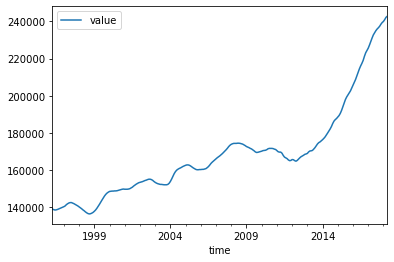

In [11]:
melt_data(austin_city[austin_city['RegionName'] == 78660]).plot();

In [12]:
# Melting data for each zipcode in Austin area:
df = pd.DataFrame()
for i in austin_city['RegionName']:
    x = melt_data(austin_city[austin_city['RegionName'] == i])  
    df = pd.concat([df, x], axis=1)
    df.rename(columns = {'value':i}, inplace = True)
# Look into the new dataframe
df

76530     76574     78602     78610     78612     78613  \
time                                                                     
1996-04-01       NaN   85900.0   74400.0  149200.0   76500.0  169600.0   
1996-05-01       NaN   86100.0   74700.0  148600.0   76300.0  169000.0   
1996-06-01       NaN   86300.0   75100.0  148200.0   76100.0  168600.0   
1996-07-01       NaN   86500.0   75700.0  148100.0   76000.0  168500.0   
1996-08-01       NaN   86600.0   76200.0  148100.0   75900.0  168700.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  144700.0  171800.0  191700.0  258000.0  200700.0  296200.0   
2018-01-01  145500.0  173100.0  191400.0  256900.0  200600.0  295900.0   
2018-02-01  152600.0  173900.0  192000.0  257200.0  203000.0  296400.0   
2018-03-01  161700.0  174200.0  194700.0  258900.0  208100.0  297500.0   
2018-04-01  163800.0  173700.0  197500.0  260000.0  212400.0  297300.0   

               78616     78617     78619     78620     78621     78626  \
time                                                                     
1996-04-01       NaN  121900.0  298000.0  213300.0   82700.0  132900.0   
1996-05-01       NaN  120500.0  298000.0  213300.0   82900.0  132700.0   
1996-06-01       NaN  119000.0  297900.0  213400.0   83100.0  132500.0   
1996-07-01       NaN  117400.0  297800.0  213400.0   83400.0  132300.0   
1996-08-01       NaN  116000.0  297700.0  213400.0   83700.0  132200.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  137000.0  182100.0  479400.0  417900.0  171600.0  232000.0   
2018-01-01  136800.0  183100.0  478100.0  420900.0  171500.0  233700.0   
2018-02-01  138500.0  184300.0  482100.0  425800.0  172100.0  234700.0   
2018-03-01  143000.0  186000.0  497500.0  433200.0  174100.0  235300.0   
2018-04-01  145900.0  187100.0  513000.0  438700.0  176000.0  235800.0   

               78628     78633     78634     78640     78641     78642  \
time                                                                     
1996-04-01  170900.0  166100.0  133200.0  112500.0  153600.0  187700.0   
1996-05-01  170800.0  166200.0  132800.0  111200.0  152900.0  187900.0   
1996-06-01  170800.0  166500.0  132400.0  110100.0  152400.0  188300.0   
1996-07-01  170900.0  167100.0  132200.0  109500.0  152000.0  188800.0   
1996-08-01  171100.0  167900.0  132100.0  109200.0  151900.0  189500.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  308600.0  311500.0  218800.0  205100.0  251200.0  352000.0   
2018-01-01  309000.0  311700.0  219200.0  204900.0  251900.0  352800.0   
2018-02-01  310600.0  312900.0  220700.0  205700.0  252800.0  356600.0   
2018-03-01  313900.0  316100.0  222200.0  207800.0  253700.0  360900.0   
2018-04-01  316800.0  318400.0  222500.0  208900.0  254100.0  362900.0   

               78644     78645     78648     78652     78653     78655  \
time                                                                     
1996-04-01   52500.0  146800.0   25000.0  144600.0  120100.0   68600.0   
1996-05-01   52800.0  147800.0   25200.0  144600.0  118300.0   69000.0   
1996-06-01   53100.0  148700.0   25500.0  144700.0  116500.0   69400.0   
1996-07-01   53400.0  149300.0   25800.0  144700.0  114800.0   69900.0   
1996-08-01   53600.0  149800.0   26100.0  144800.0  113300.0   70300.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  144400.0  268500.0  103000.0  306700.0  195800.0  217100.0   
2018-01-01  144200.0  267900.0  103300.0  306400.0  196300.0  217700.0   
2018-02-01  145000.0  269400.0  104100.0  307400.0  196800.0  219500.0   
2018-03-01  146200.0  273000.0  105900.0  309400.0  196900.0  221600.0   
2018-04-01  146500.0  275300.0  107000.0  310800.0  196900.0  222300.0   

               78659     78660     78664     78665     78666     78669  \
time                                                                     
1996-04-01   54

In [13]:
df_final = df[df.index.year > 2008]
df_final

76530     76574     78602     78610     78612     78613  \
time                                                                     
2009-01-01  110700.0  112200.0  123000.0  190200.0  128500.0  205300.0   
2009-02-01  111100.0  112200.0  122400.0  189500.0  127700.0  205000.0   
2009-03-01  111800.0  112300.0  121700.0  188800.0  127000.0  204700.0   
2009-04-01  112600.0  112400.0  121000.0  188100.0  126100.0  204600.0   
2009-05-01  113100.0  112400.0  120200.0  187500.0  125200.0  204300.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  144700.0  171800.0  191700.0  258000.0  200700.0  296200.0   
2018-01-01  145500.0  173100.0  191400.0  256900.0  200600.0  295900.0   
2018-02-01  152600.0  173900.0  192000.0  257200.0  203000.0  296400.0   
2018-03-01  161700.0  174200.0  194700.0  258900.0  208100.0  297500.0   
2018-04-01  163800.0  173700.0  197500.0  260000.0  212400.0  297300.0   

               78616     78617     78619     78620     78621     78626  \
time                                                                     
2009-01-01   92900.0  131400.0  383600.0  287000.0  118800.0  156900.0   
2009-02-01   92200.0  130800.0  381300.0  284900.0  118200.0  156500.0   
2009-03-01   91600.0  130100.0  379400.0  283100.0  117700.0  156100.0   
2009-04-01   91000.0  129300.0  378300.0  281400.0  117000.0  155900.0   
2009-05-01   90400.0  128600.0  377400.0  279800.0  116100.0  155800.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  137000.0  182100.0  479400.0  417900.0  171600.0  232000.0   
2018-01-01  136800.0  183100.0  478100.0  420900.0  171500.0  233700.0   
2018-02-01  138500.0  184300.0  482100.0  425800.0  172100.0  234700.0   
2018-03-01  143000.0  186000.0  497500.0  433200.0  174100.0  235300.0   
2018-04-01  145900.0  187100.0  513000.0  438700.0  176000.0  235800.0   

               78628     78633     78634     78640     78641     78642  \
time                                                                     
2009-01-01  231200.0  226300.0  152900.0  150600.0  175900.0  241900.0   
2009-02-01  230300.0  225200.0  152000.0  149900.0  175400.0  241500.0   
2009-03-01  229600.0  224400.0  151300.0  149300.0  174900.0  241300.0   
2009-04-01  229300.0  223700.0  150700.0  148800.0  174500.0  241000.0   
2009-05-01  228900.0  222900.0  150200.0  148200.0  174200.0  240600.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  308600.0  311500.0  218800.0  205100.0  251200.0  352000.0   
2018-01-01  309000.0  311700.0  219200.0  204900.0  251900.0  352800.0   
2018-02-01  310600.0  312900.0  220700.0  205700.0  252800.0  356600.0   
2018-03-01  313900.0  316100.0  222200.0  207800.0  253700.0  360900.0   
2018-04-01  316800.0  318400.0  222500.0  208900.0  254100.0  362900.0   

               78644     78645     78648     78652     78653     78655  \
time                                                                     
2009-01-01  106200.0  193200.0   73600.0  194800.0  142600.0  148200.0   
2009-02-01  106100.0  193300.0   73700.0  193700.0  141900.0  147700.0   
2009-03-01  106000.0  193300.0   73800.0  192600.0  141300.0  147400.0   
2009-04-01  105800.0  193300.0   73900.0  191100.0  140800.0  147300.0   
2009-05-01  105600.0  193400.0   74000.0  189500.0  140300.0  147100.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  144400.0  268500.0  103000.0  306700.0  195800.0  217100.0   
2018-01-01  144200.0  267900.0  103300.0  306400.0  196300.0  217700.0   
2018-02-01  145000.0  269400.0  104100.0  307400.0  196800.0  219500.0   
2018-03-01  146200.0  273000.0  105900.0  309400.0  196900.0  221600.0   
2018-04-01  146500.0  275300.0  107000.0  310800.0  196900.0  222300.0   

               78659     78660     78664     78665     78666     78669  \
time                                                                     
2009-01-01  108

In [14]:
df_final.isna().sum().sum()  # no missing values!

0

In [15]:
fig = px.line(df_final, title='Median House Prices')
fig.show()

# Step 3: EDA and Visualization

In [16]:
# Return for each zipcode!  
# Percentage change between the current and a prior element.
# (current homeprice - previous homeprice)/previous homeprice
df_return = df_final.pct_change()
df_return

76530     76574     78602     78610     78612     78613  \
time                                                                     
2009-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
2009-02-01  0.003613  0.000000 -0.004878 -0.003680 -0.006226 -0.001461   
2009-03-01  0.006301  0.000891 -0.005719 -0.003694 -0.005482 -0.001463   
2009-04-01  0.007156  0.000890 -0.005752 -0.003708 -0.007087 -0.000489   
2009-05-01  0.004440  0.000000 -0.006612 -0.003190 -0.007137 -0.001466   
...              ...       ...       ...       ...       ...       ...   
2017-12-01 -0.003444  0.006444 -0.004673 -0.002706 -0.003476  0.001352   
2018-01-01  0.005529  0.007567 -0.001565 -0.004264 -0.000498 -0.001013   
2018-02-01  0.048797  0.004622  0.003135  0.001168  0.011964  0.001690   
2018-03-01  0.059633  0.001725  0.014063  0.006610  0.025123  0.003711   
2018-04-01  0.012987 -0.002870  0.014381  0.004249  0.020663 -0.000672   

               78616     78617     78619     78620     78621     78626  \
time                                                                     
2009-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
2009-02-01 -0.007535 -0.004566 -0.005996 -0.007317 -0.005051 -0.002549   
2009-03-01 -0.006508 -0.005352 -0.004983 -0.006318 -0.004230 -0.002556   
2009-04-01 -0.006550 -0.006149 -0.002899 -0.006005 -0.005947 -0.001281   
2009-05-01 -0.006593 -0.005414 -0.002379 -0.005686 -0.007692 -0.000641   
...              ...       ...       ...       ...       ...       ...   
2017-12-01 -0.002185  0.003306  0.001462  0.007716 -0.001745  0.010893   
2018-01-01 -0.001460  0.005491 -0.002712  0.007179 -0.000583  0.007328   
2018-02-01  0.012427  0.006554  0.008366  0.011642  0.003499  0.004279   
2018-03-01  0.032491  0.009224  0.031944  0.017379  0.011621  0.002556   
2018-04-01  0.020280  0.005914  0.031156  0.012696  0.010913  0.002125   

               78628     78633     78634     78640     78641     78642  \
time                                                                     
2009-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
2009-02-01 -0.003893 -0.004861 -0.005886 -0.004648 -0.002843 -0.001654   
2009-03-01 -0.003040 -0.003552 -0.004605 -0.004003 -0.002851 -0.000828   
2009-04-01 -0.001307 -0.003119 -0.003966 -0.003349 -0.002287 -0.001243   
2009-05-01 -0.001744 -0.003576 -0.003318 -0.004032 -0.001719 -0.001660   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  0.002925  0.007764  0.005515  0.000488  0.003997  0.001707   
2018-01-01  0.001296  0.000642  0.001828 -0.000975  0.002787  0.002273   
2018-02-01  0.005178  0.003850  0.006843  0.003904  0.003573  0.010771   
2018-03-01  0.010625  0.010227  0.006797  0.010209  0.003560  0.012058   
2018-04-01  0.009239  0.007276  0.001350  0.005294  0.001577  0.005542   

               78644     78645     78648     78652     78653     78655  \
time                                                                     
2009-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
2009-02-01 -0.000942  0.000518  0.001359 -0.005647 -0.004909 -0.003374   
2009-03-01 -0.000943  0.000000  0.001357 -0.005679 -0.004228 -0.002031   
2009-04-01 -0.001887  0.000000  0.001355 -0.007788 -0.003539 -0.000678   
2009-05-01 -0.001890  0.000517  0.001353 -0.008373 -0.003551 -0.001358   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  0.000000 -0.001859  0.005859 -0.002926  0.002047  0.002771   
2018-01-01 -0.001385 -0.002235  0.002913 -0.000978  0.002554  0.002764   
2018-02-01  0.005548  0.005599  0.007744  0.003264  0.002547  0.008268   
2018-03-01  0.008276  0.013363  0.017291  0.006506  0.000508  0.009567   
2018-04-01  0.002052  0.008425  0.010387  0.004525  0.000000  0.003159   

               78659     78660     78664     78665     78666     78669  \
time                                                                     
2009-01-01     

In [17]:
# we will drop the first row of the df_return dataframe:
df_return.dropna(axis=0, inplace=True)

In [18]:
zcdb = ZipCodeDatabase()

In [19]:
austin_map = pd.DataFrame(data=df_return.mean())
austin_map.rename(columns = {0:'ReturnMean'}, inplace = True)
austin_map.drop(78633, axis=0, inplace=True)   # zipcode:78633 is missing in ZipCodeDatabase()

long = []
lat = []
cumsum = []
for i in austin_map.index:
    long.append(zcdb[i].longitude)
    lat.append(zcdb[i].latitude)
    cumsum.append(df_return[i].cumsum()[-1])
    
austin_map['long'] =long
austin_map['lat']=lat
austin_map['CumulativeReturn'] = cumsum

austin_map = austin_map.reset_index()
austin_map.rename(columns = {'index':'Zipcode'}, inplace = True)
austin_map

Zipcode  ReturnMean      long        lat  CumulativeReturn
0     76530    0.003737 -97.43449  30.715207          0.414755
1     76574    0.003978 -97.40948  30.574821          0.441586
2     78602    0.004298 -97.30991  30.120443          0.477031
3     78610    0.002831 -97.81780  30.077030          0.314224
4     78612    0.004575 -97.49055  30.130116          0.507788
..      ...         ...       ...        ...               ...
67    78756    0.003324 -97.74177  30.320206          0.368966
68    78757    0.004111 -97.73328  30.349455          0.456295
69    78758    0.005763 -97.70392  30.384204          0.639645
70    78759    0.003527 -97.75743  30.406169          0.391504
71    78957    0.005269 -97.16036  30.010487          0.584862

[72 rows x 5 columns]

In [20]:
# Explore relationship between percent return and zipcode
fig = px.scatter_mapbox(data_frame = austin_map, # df name
                        lat='lat', # name of latitude column
                        lon='long', # name of longitude column
                        color='CumulativeReturn', # name of column to use for the color
                        zoom=7.5)

fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [21]:
#[Latitude ,Longitude]
Austin = folium.Map(location=[30.267153, -97.7430608])

tooltip = "Austin!"
folium.Marker(
    [30.267153, -97.7430608], popup="<i>TestClick</i>", tooltip=tooltip
).add_to(Austin)


Austin

# Step 4: ARIMA Modeling

In [22]:
# Our final dataset for the time series analysis:
df_final

76530     76574     78602     78610     78612     78613  \
time                                                                     
2009-01-01  110700.0  112200.0  123000.0  190200.0  128500.0  205300.0   
2009-02-01  111100.0  112200.0  122400.0  189500.0  127700.0  205000.0   
2009-03-01  111800.0  112300.0  121700.0  188800.0  127000.0  204700.0   
2009-04-01  112600.0  112400.0  121000.0  188100.0  126100.0  204600.0   
2009-05-01  113100.0  112400.0  120200.0  187500.0  125200.0  204300.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  144700.0  171800.0  191700.0  258000.0  200700.0  296200.0   
2018-01-01  145500.0  173100.0  191400.0  256900.0  200600.0  295900.0   
2018-02-01  152600.0  173900.0  192000.0  257200.0  203000.0  296400.0   
2018-03-01  161700.0  174200.0  194700.0  258900.0  208100.0  297500.0   
2018-04-01  163800.0  173700.0  197500.0  260000.0  212400.0  297300.0   

               78616     78617     78619     78620     78621     78626  \
time                                                                     
2009-01-01   92900.0  131400.0  383600.0  287000.0  118800.0  156900.0   
2009-02-01   92200.0  130800.0  381300.0  284900.0  118200.0  156500.0   
2009-03-01   91600.0  130100.0  379400.0  283100.0  117700.0  156100.0   
2009-04-01   91000.0  129300.0  378300.0  281400.0  117000.0  155900.0   
2009-05-01   90400.0  128600.0  377400.0  279800.0  116100.0  155800.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  137000.0  182100.0  479400.0  417900.0  171600.0  232000.0   
2018-01-01  136800.0  183100.0  478100.0  420900.0  171500.0  233700.0   
2018-02-01  138500.0  184300.0  482100.0  425800.0  172100.0  234700.0   
2018-03-01  143000.0  186000.0  497500.0  433200.0  174100.0  235300.0   
2018-04-01  145900.0  187100.0  513000.0  438700.0  176000.0  235800.0   

               78628     78633     78634     78640     78641     78642  \
time                                                                     
2009-01-01  231200.0  226300.0  152900.0  150600.0  175900.0  241900.0   
2009-02-01  230300.0  225200.0  152000.0  149900.0  175400.0  241500.0   
2009-03-01  229600.0  224400.0  151300.0  149300.0  174900.0  241300.0   
2009-04-01  229300.0  223700.0  150700.0  148800.0  174500.0  241000.0   
2009-05-01  228900.0  222900.0  150200.0  148200.0  174200.0  240600.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  308600.0  311500.0  218800.0  205100.0  251200.0  352000.0   
2018-01-01  309000.0  311700.0  219200.0  204900.0  251900.0  352800.0   
2018-02-01  310600.0  312900.0  220700.0  205700.0  252800.0  356600.0   
2018-03-01  313900.0  316100.0  222200.0  207800.0  253700.0  360900.0   
2018-04-01  316800.0  318400.0  222500.0  208900.0  254100.0  362900.0   

               78644     78645     78648     78652     78653     78655  \
time                                                                     
2009-01-01  106200.0  193200.0   73600.0  194800.0  142600.0  148200.0   
2009-02-01  106100.0  193300.0   73700.0  193700.0  141900.0  147700.0   
2009-03-01  106000.0  193300.0   73800.0  192600.0  141300.0  147400.0   
2009-04-01  105800.0  193300.0   73900.0  191100.0  140800.0  147300.0   
2009-05-01  105600.0  193400.0   74000.0  189500.0  140300.0  147100.0   
...              ...       ...       ...       ...       ...       ...   
2017-12-01  144400.0  268500.0  103000.0  306700.0  195800.0  217100.0   
2018-01-01  144200.0  267900.0  103300.0  306400.0  196300.0  217700.0   
2018-02-01  145000.0  269400.0  104100.0  307400.0  196800.0  219500.0   
2018-03-01  146200.0  273000.0  105900.0  309400.0  196900.0  221600.0   
2018-04-01  146500.0  275300.0  107000.0  310800.0  196900.0  222300.0   

               78659     78660     78664     78665     78666     78669  \
time                                                                     
2009-01-01  108

#### Choose a representative zipcode for analysis -  ZIPCODE: 76530 

In [23]:
# Representative zipcode:
df_final[76530]

time
2009-01-01    110700.0
2009-02-01    111100.0
2009-03-01    111800.0
2009-04-01    112600.0
2009-05-01    113100.0
                ...   
2017-12-01    144700.0
2018-01-01    145500.0
2018-02-01    152600.0
2018-03-01    161700.0
2018-04-01    163800.0
Freq: MS, Name: 76530, Length: 112, dtype: float64

In [24]:
# Let's  get the rolling mean and rolling standard deviation, using a 12-month window

roll_mean = df_final[76530].rolling(window=12, center=False).mean()
roll_std = df_final[76530].rolling(window=12, center=False).std()

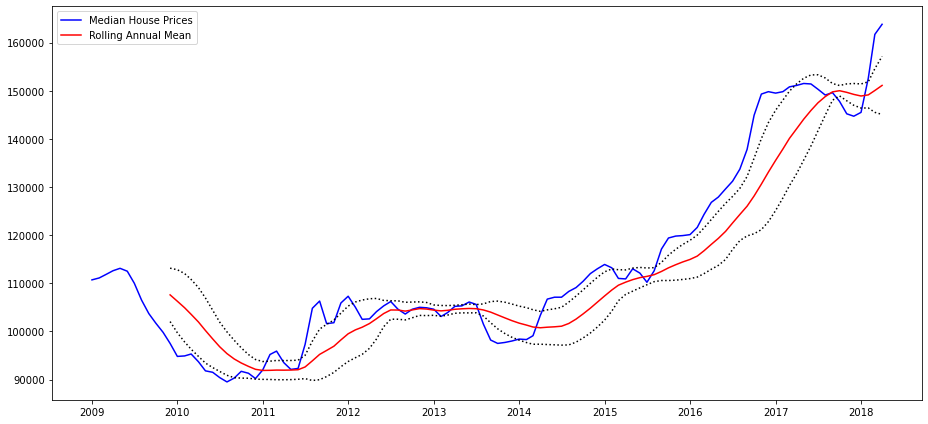

In [25]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_final[76530], color='blue',
        label='Median House Prices')

ax.plot(roll_mean, color='red', label='Rolling Annual Mean')

ax.plot(roll_mean + roll_std, color='black', linestyle='dotted')
ax.plot(roll_mean - roll_std, color='black', linestyle='dotted')

ax.legend()
fig.tight_layout()

 - Data is not stationary, it has upward trend!

In [26]:
# Stationarty test for original data:
adfuller(df_final[76530])

(0.340170474119402,
 0.9791142548981822,
 5,
 106,
 {'1%': -3.4936021509366793,
  '5%': -2.8892174239808703,
  '10%': -2.58153320754717},
 1716.2283400507104)

In [27]:
# Taking the log transform:
adfuller(np.log(df_final[76530]))

(-0.019805726747088248,
 0.9568631951601224,
 5,
 106,
 {'1%': -3.4936021509366793,
  '5%': -2.8892174239808703,
  '10%': -2.58153320754717},
 -571.1166900711175)

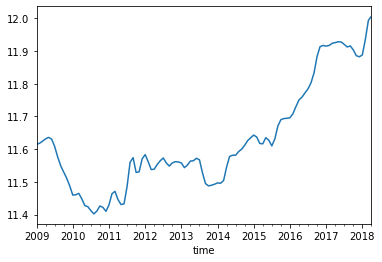

In [28]:
np.log(df_final[76530]).plot();

In [29]:
# Taking difference to make data stationary:
diff_df = df_final[76530].diff(periods=2).dropna()
adfuller(diff_df)

(-2.9118028698477962,
 0.04399259917002659,
 9,
 100,
 {'1%': -3.497501033, '5%': -2.89090644, '10%': -2.5824349},
 1692.896473271386)

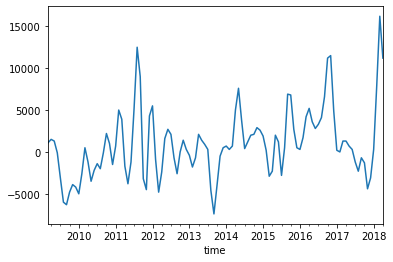

In [30]:
diff_df.plot();

In [31]:
# Subtacting rolling average:
df_minus_roll_mean = df_final[76530] - roll_mean
df_minus_roll_mean.dropna(inplace=True)
adfuller(df_minus_roll_mean)

(-3.4128672403896867,
 0.010527971472219164,
 5,
 95,
 {'1%': -3.5011373281819504,
  '5%': -2.8924800524857854,
  '10%': -2.5832749307479226},
 1512.8539479184778)

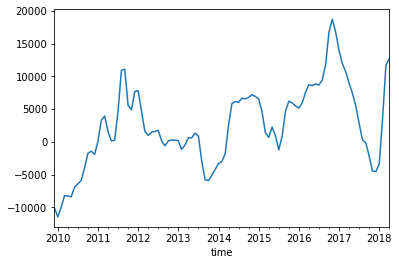

In [32]:
df_minus_roll_mean.plot();

In [33]:
# Weighted rolling mean:
exp_roll_mean = df_final[76530].ewm(halflife=2).mean()
adfuller(df_final[76530] - exp_roll_mean)

(-2.8457225070004637,
 0.05203360085264322,
 5,
 106,
 {'1%': -3.4936021509366793,
  '5%': -2.8892174239808703,
  '10%': -2.58153320754717},
 1647.343821045775)

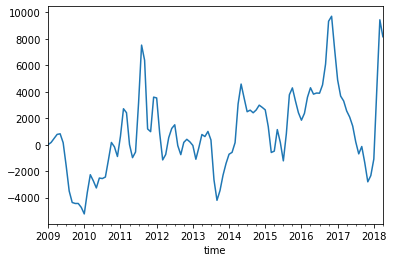

In [34]:
(df_final[76530] - exp_roll_mean).plot();

In [35]:
# Function is from Centaur Group:
def run_auto_arima(series):
    
    gridsearch = pm.auto_arima(series,
                            start_p = 0,
                            max_p = 3,
                            d = 0, 
                            max_d = 3, 
                            start_q = 0,
                            max_q = 3,
                            seasonal=True,
                            m = 12,
                            suppress_warnings=True, error_action='ignore')
    
    model = ARIMA(series, 
                  order = gridsearch.order, 
                  seasonal_order = gridsearch.seasonal_order,
                  enforce_stationarity=False)

    
    return model.fit()

In [36]:
# Function is written together with Centaur Group:
def run_arima_model(series, start, end):
    
    logged_series = np.log(series)
    
    model = run_auto_arima(logged_series)
    
    log_prediction = model.predict(start, end)  # .predict() : both insample prediction and out of sample forecast
    
    log_forecast = model.get_forecast(36)   # we forecast 36 more months!
    
    prediction = np.e ** log_prediction
    
    forecast = np.e** log_forecast.summary_frame()
    
    prediction_df = pd.DataFrame(prediction.values, prediction.index)
    
    return series, prediction_df, forecast

- We have 112 months in our series  for each zipcode.
- We want to forecast 12 more months.
- End date = 124 

In [37]:
original_series, prediction_series, forecast = run_arima_model(df_final[76530], 0, 124)

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [38]:
forecast

76530                mean   mean_se  mean_ci_lower  mean_ci_upper
2018-05-01  160699.795437  1.012373  156872.920925  164620.025568
2018-06-01  159570.190608  1.035417  149048.072031  170835.123083
2018-07-01  158830.684390  1.057559  142330.481597  177243.735992
2018-08-01  158108.257989  1.073133  137681.327294  181565.806604
2018-09-01  157402.456546  1.085717  133970.138803  184933.251156
...                   ...       ...            ...            ...
2020-12-01  143297.183586  1.210330   98570.952580  208317.788214
2021-01-01  142918.589684  1.212298   97997.949953  208430.107845
2021-02-01  142548.006461  1.214182   97446.955908  208523.026263
2021-03-01  142185.246744  1.215984   96916.808042  208597.918156
2021-04-01  141830.128388  1.217709   96406.428512  208656.057785

[36 rows x 4 columns]

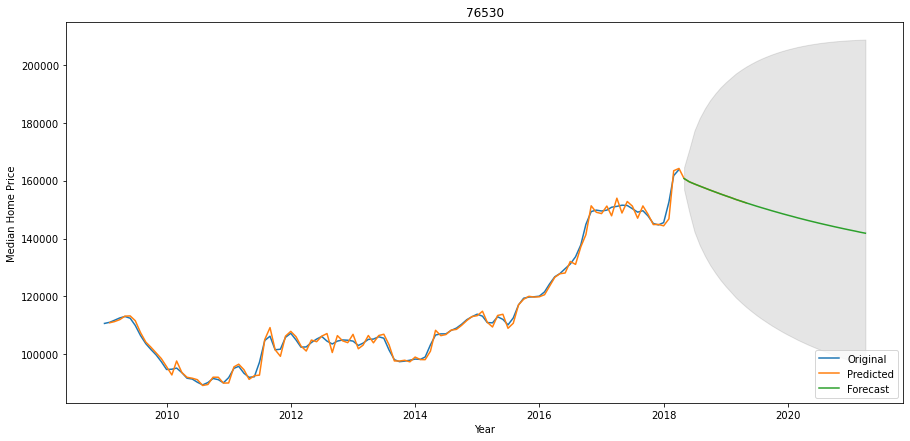

In [39]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(df_final[76530])
plt.plot(prediction_series[1:])
plt.plot(forecast['mean'])
ax.fill_between(forecast.index, forecast['mean_ci_lower'], forecast['mean_ci_upper'], color='k', alpha=0.1);
plt.title('76530')
plt.legend(['Original','Predicted', 'Forecast'], loc='lower right')
plt.xlabel('Year')
plt.ylabel('Median Home Price')
plt.show()

In [40]:
# metrics  - Copy from TS review
def report_metrics(y_true, y_pred):
    print("Explained Variance:\n\t", metrics.explained_variance_score(y_true, y_pred))
    print("MAE:\n\t", metrics.mean_absolute_error(y_true, y_pred))
    print("RMSE:\n\t", metrics.mean_squared_error(y_true, y_pred, squared=False))
    print("r^2:\n\t", metrics.r2_score(y_true, y_pred))
    

report_metrics(df_final[76530][1:], prediction_series[1:-13])   

Explained Variance:
	 0.9944714054986129
MAE:
	 1058.4473607191453
RMSE:
	 1442.4532480317084
r^2:
	 0.994462395709627


#### Run ARIMA model with Train-Test Split: 

In [41]:
# Train-test split
cutoff = '2016-04-01'

# Define train and test sets according to the index found above
train = df_final[76530][:cutoff]

test = df_final[76530][cutoff:]

In [42]:
original_series, prediction_series, forecast = run_arima_model(train, 0, 124)

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



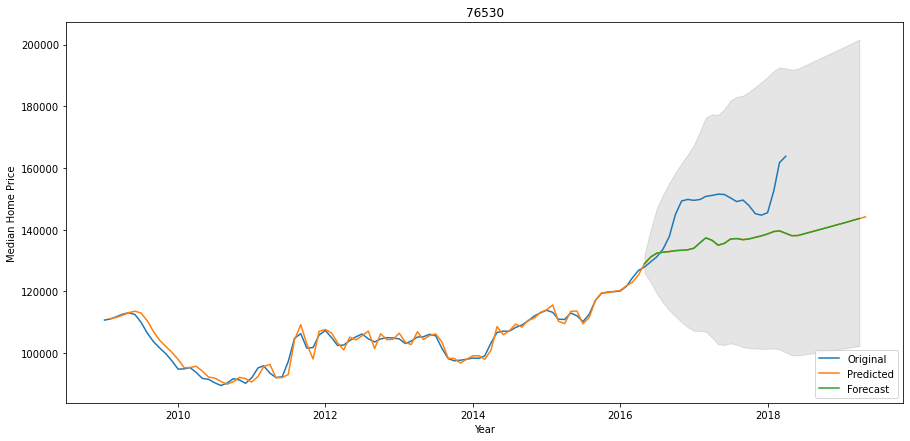

In [43]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(df_final[76530])
plt.plot(prediction_series[1:])
plt.plot(forecast['mean'])
ax.fill_between(forecast.index, forecast['mean_ci_lower'], forecast['mean_ci_upper'], color='k', alpha=0.1);
plt.title('76530')
plt.legend(['Original','Predicted', 'Forecast'], loc='lower right')
plt.xlabel('Year')
plt.ylabel('Median Home Price')
plt.show()

In [44]:
# metrics  - Copy from TS review
def report_metrics(y_true, y_pred):
    print("Explained Variance:\n\t", metrics.explained_variance_score(y_true, y_pred))
    print("MAE:\n\t", metrics.mean_absolute_error(y_true, y_pred))
    print("RMSE:\n\t", metrics.mean_squared_error(y_true, y_pred, squared=False))
    print("r^2:\n\t", metrics.r2_score(y_true, y_pred))
    
# take out the first value because model predicts badly at first!
report_metrics(df_final[76530][1:], prediction_series[1:-13])

Explained Variance:
	 0.909162232267951
MAE:
	 3411.553100077576
RMSE:
	 6221.262686536085
r^2:
	 0.8969909207397229


In [45]:
df_final[76530][1:]

time
2009-02-01    111100.0
2009-03-01    111800.0
2009-04-01    112600.0
2009-05-01    113100.0
2009-06-01    112500.0
                ...   
2017-12-01    144700.0
2018-01-01    145500.0
2018-02-01    152600.0
2018-03-01    161700.0
2018-04-01    163800.0
Freq: MS, Name: 76530, Length: 111, dtype: float64

In [126]:
prediction_series[1:-13]

0
2009-02-01  111179.127802
2009-03-01  111580.149633
2009-04-01  112281.931719
2009-05-01  113083.958908
2009-06-01  113585.220795
...                   ...
2017-12-01  137987.695740
2018-01-01  138608.627528
2018-02-01  139398.460961
2018-03-01  139610.902408
2018-04-01  138831.135079

[111 rows x 1 columns]

In [58]:
forecast['mean'][-1]

143600.59113522663

### Forecasting all zipcodes in Austin area:

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



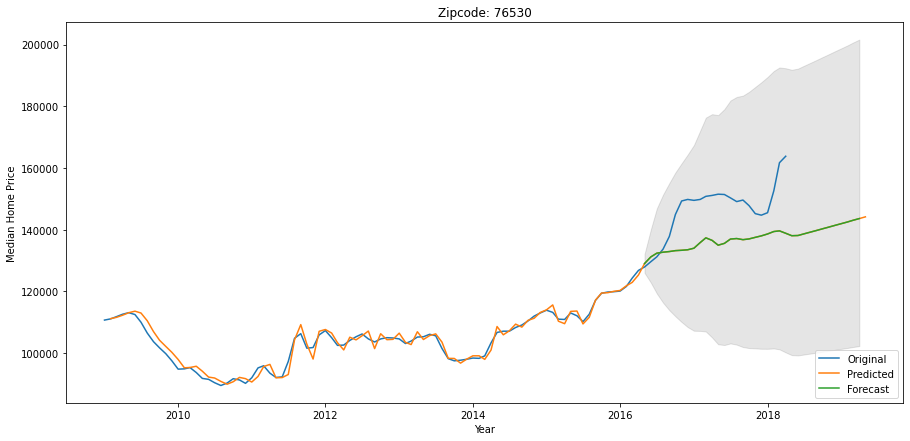

Zipcode: 76530
Explained Variance:
	 0.909162232267951
MAE:
	 3411.553100077576
RMSE:
	 6221.262686536085
r^2:
	 0.8969909207397229


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



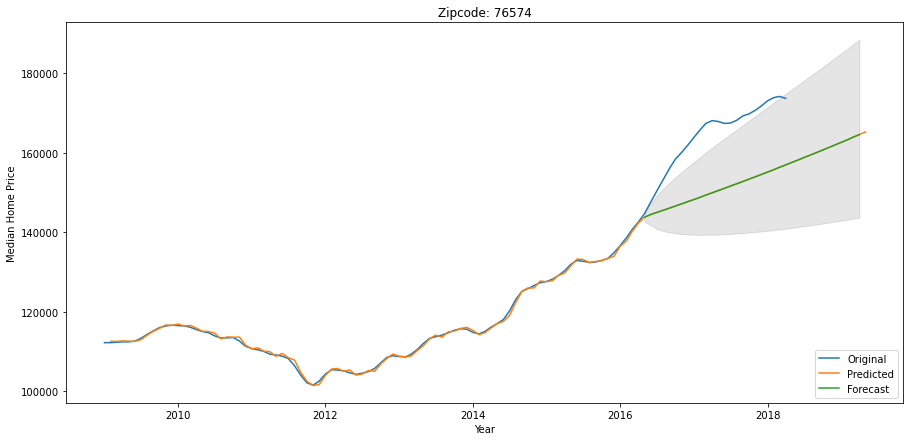

Zipcode: 76574
Explained Variance:
	 0.9194801886838533
MAE:
	 3313.1914494373527
RMSE:
	 6949.998745633775
r^2:
	 0.9003933957956365


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



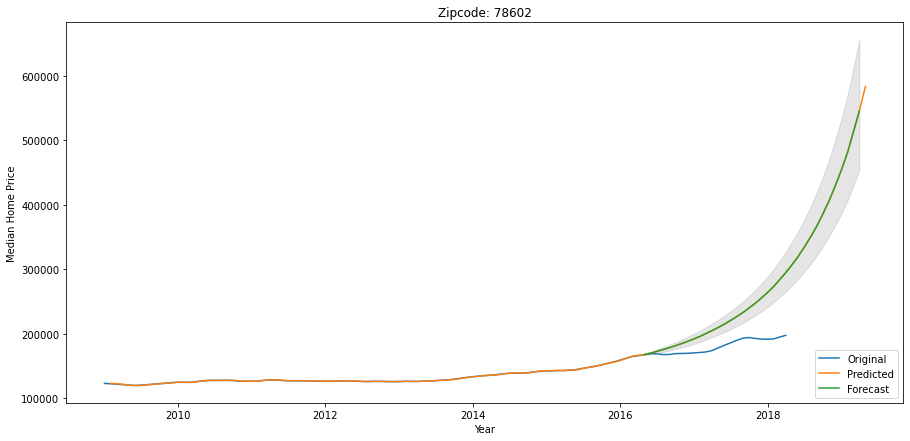

Zipcode: 78602
Explained Variance:
	 0.25091503949421345
MAE:
	 7913.630511907523
RMSE:
	 20863.738846007745
r^2:
	 0.13207226802203942


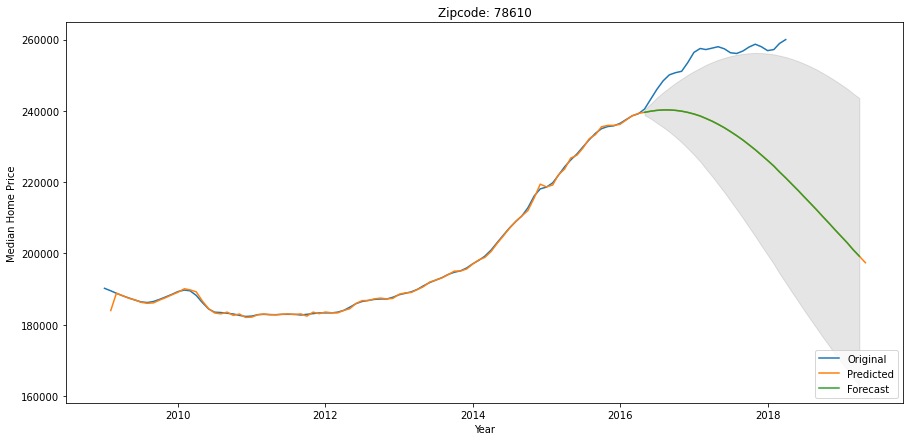

Zipcode: 78610
Explained Variance:
	 0.8878648178483416
MAE:
	 4556.313433418147
RMSE:
	 10448.851322822142
r^2:
	 0.8638258996902213


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



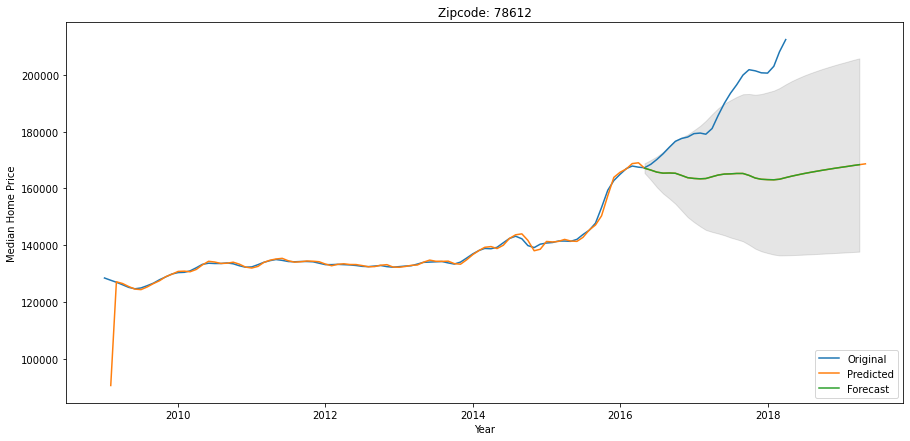

Zipcode: 78612
Explained Variance:
	 0.738420557541072
MAE:
	 5639.812749171654
RMSE:
	 12986.662391587002
r^2:
	 0.6872049247669385


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



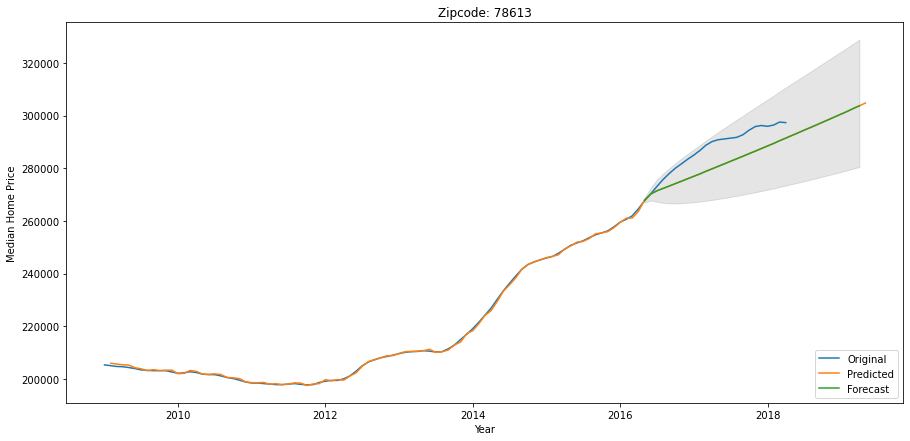

Zipcode: 78613
Explained Variance:
	 0.9915310447429279
MAE:
	 1748.9412593968468
RMSE:
	 3512.8853803611537
r^2:
	 0.9897036650385482


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



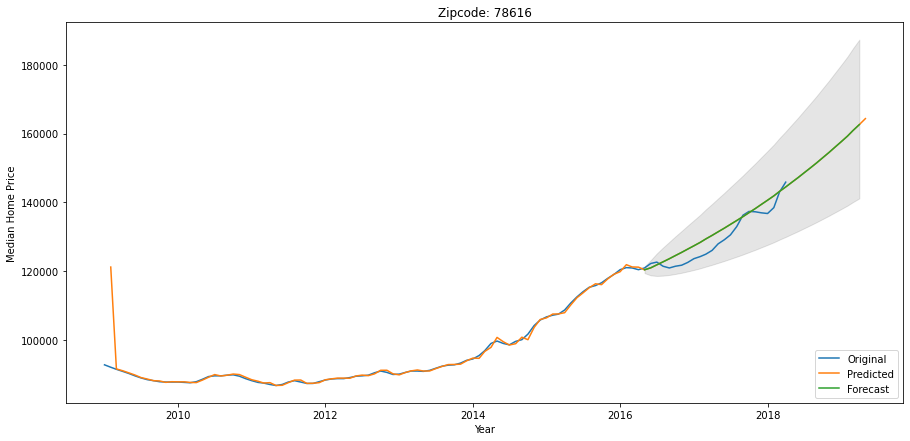

Zipcode: 78616
Explained Variance:
	 0.968871596928736
MAE:
	 1013.1911155925073
RMSE:
	 3074.726863517169
r^2:
	 0.9670962247508188


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



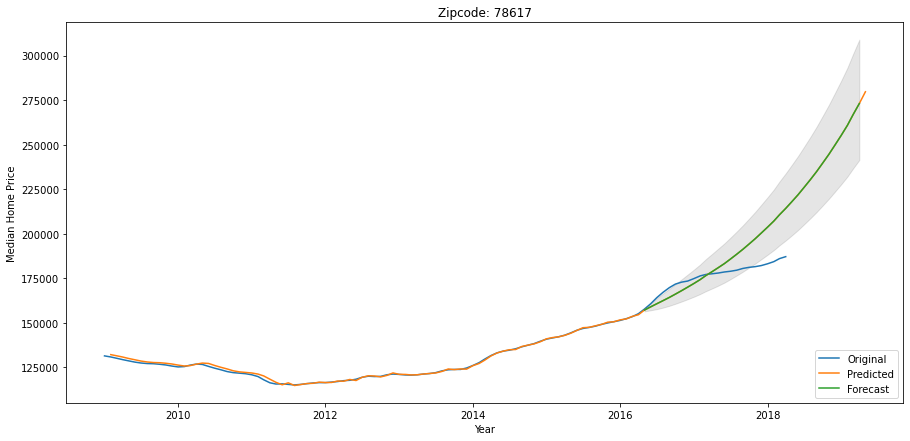

Zipcode: 78617
Explained Variance:
	 0.9407262043096282
MAE:
	 2325.939063226719
RMSE:
	 5614.294119261259
r^2:
	 0.9358610169882389


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



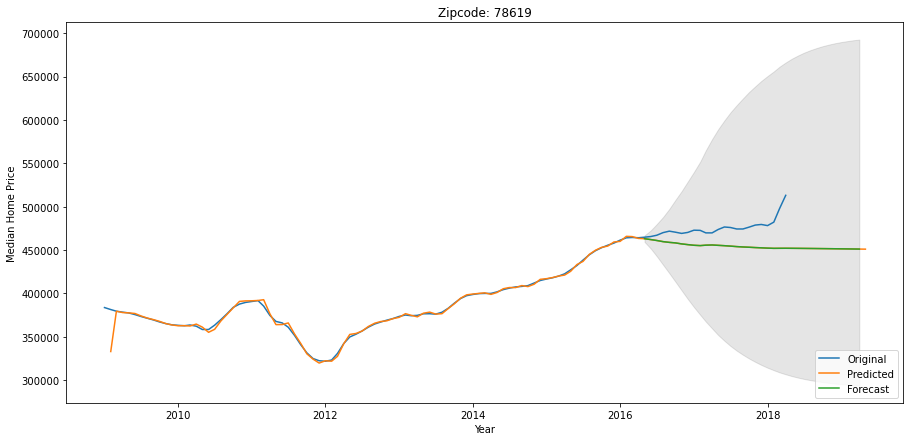

Zipcode: 78619
Explained Variance:
	 0.947697354049903
MAE:
	 5671.46894054999
RMSE:
	 11947.656497110242
r^2:
	 0.9383507828120701


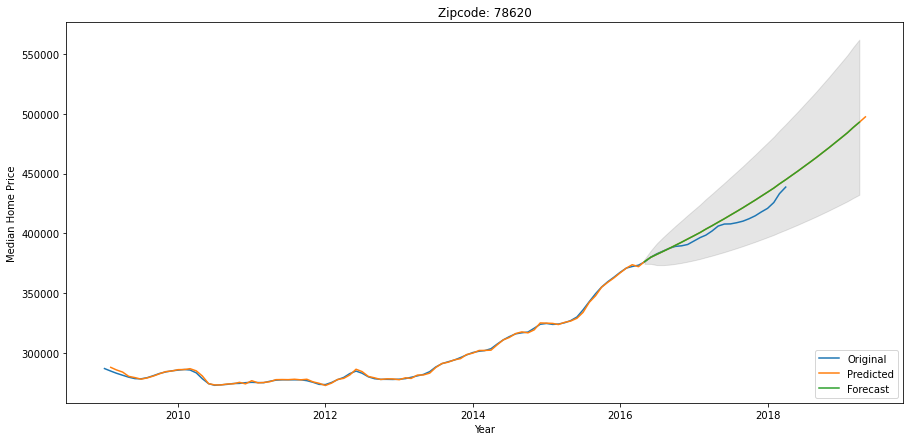

Zipcode: 78620
Explained Variance:
	 0.9957180766469141
MAE:
	 1826.4580001981572
RMSE:
	 3580.8105124615745
r^2:
	 0.9950107303411814


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



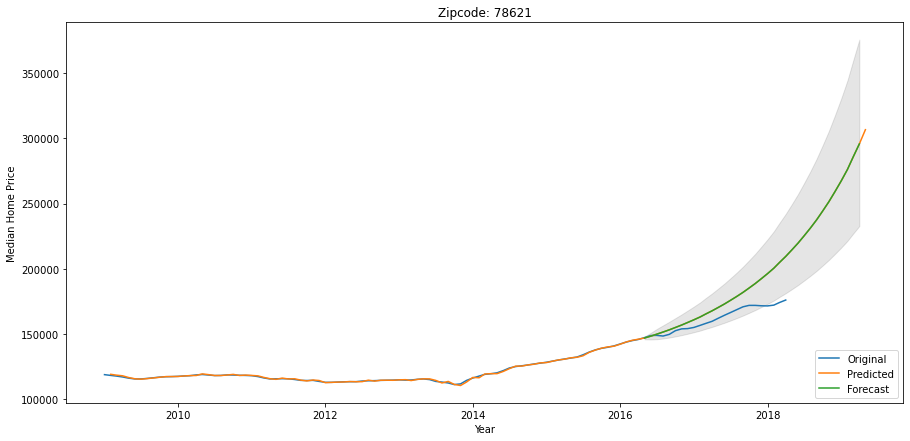

Zipcode: 78621
Explained Variance:
	 0.8892992738933012
MAE:
	 2601.520315548588
RMSE:
	 6769.234954549085
r^2:
	 0.8740482083433552


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



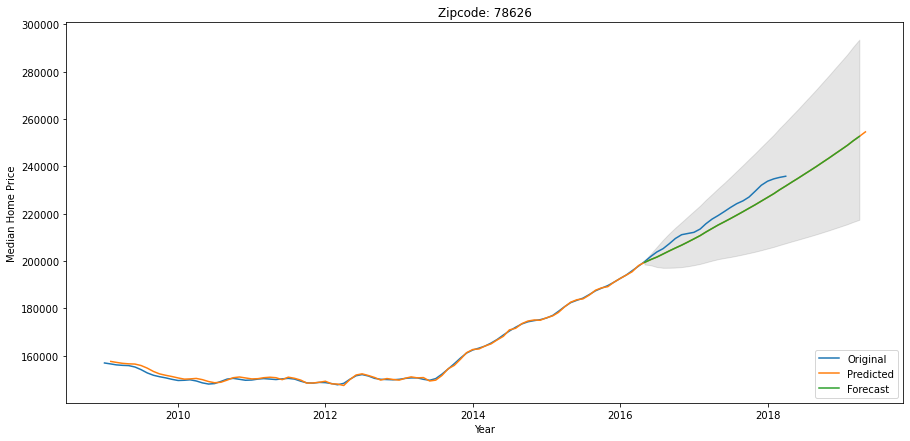

Zipcode: 78626
Explained Variance:
	 0.9949889421653906
MAE:
	 1250.474702486909
RMSE:
	 2081.2778799402745
r^2:
	 0.9944182342202443


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



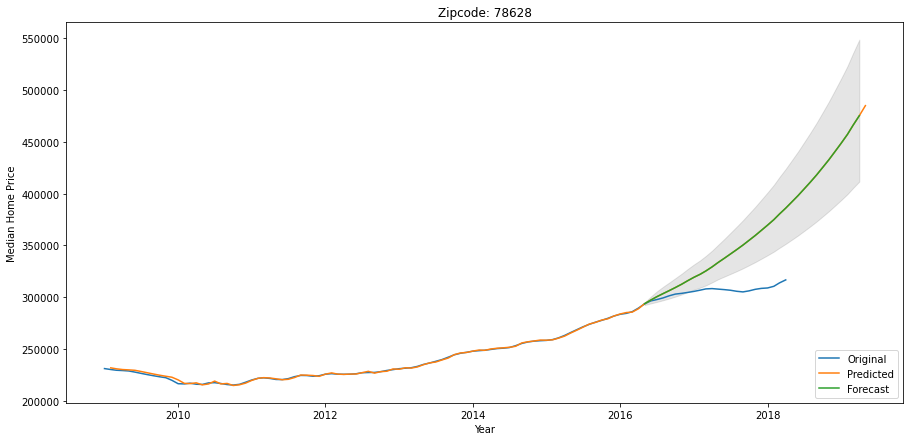

Zipcode: 78628
Explained Variance:
	 0.7661811192456791
MAE:
	 6797.868403707234
RMSE:
	 17299.447990378667
r^2:
	 0.7277827909108991


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



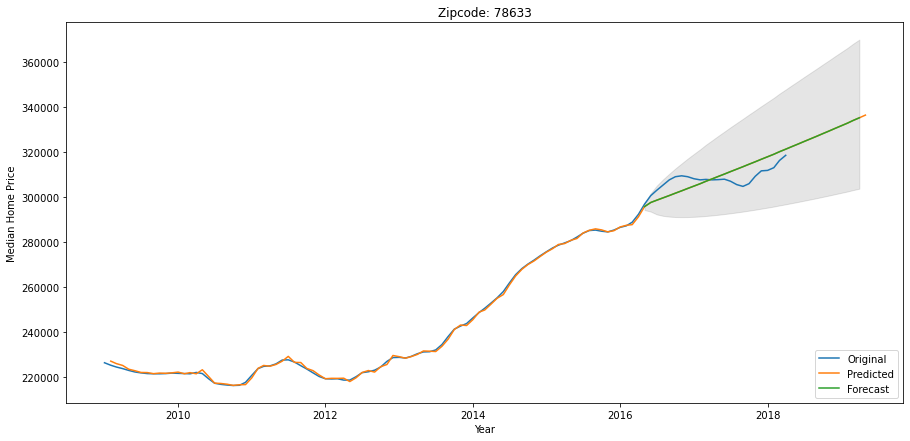

Zipcode: 78633
Explained Variance:
	 0.995183446371585
MAE:
	 1390.206309194526
RMSE:
	 2467.597406208425
r^2:
	 0.9951594065888638


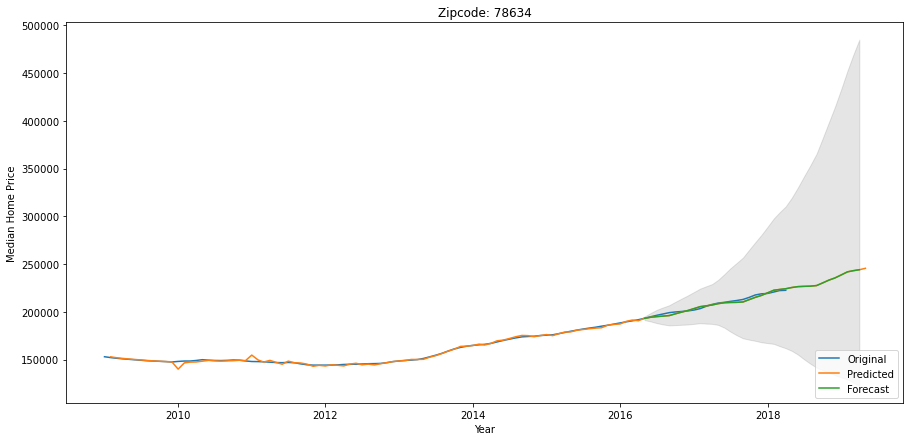

Zipcode: 78634
Explained Variance:
	 0.9966736969174443
MAE:
	 909.8635418934662
RMSE:
	 1431.3741584547913
r^2:
	 0.996606747605572


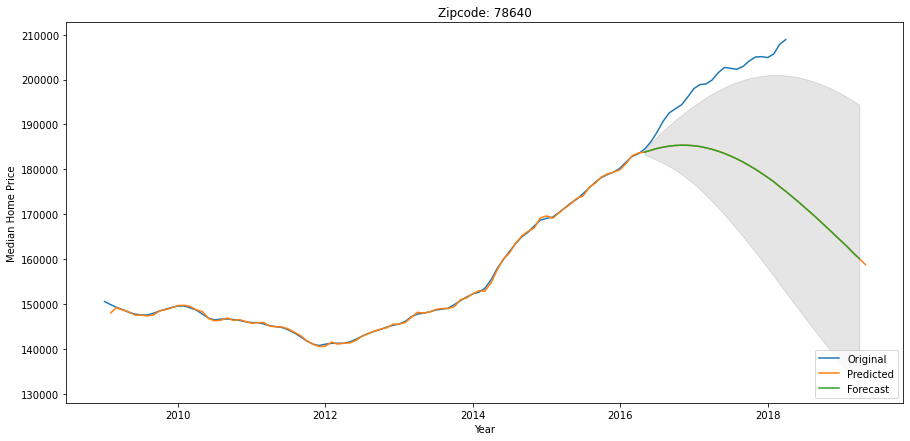

Zipcode: 78640
Explained Variance:
	 0.8649534440877593
MAE:
	 3725.229746758059
RMSE:
	 8781.357277693578
r^2:
	 0.8378031218207447


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



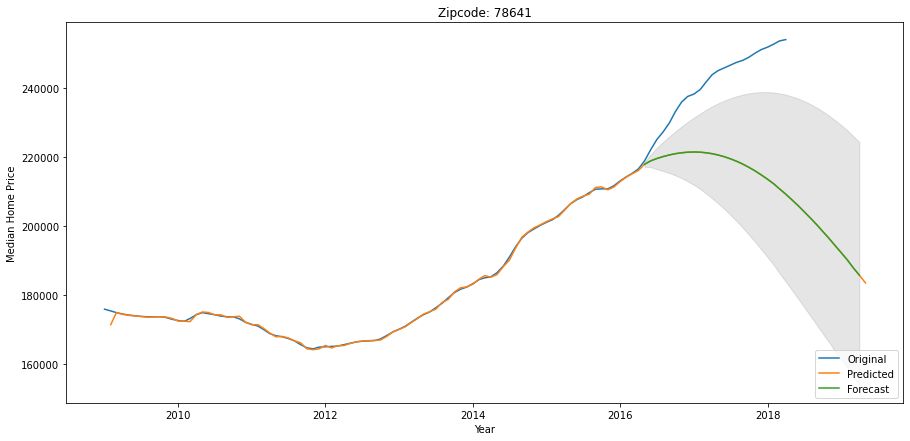

Zipcode: 78641
Explained Variance:
	 0.849460503780418
MAE:
	 5195.191542994575
RMSE:
	 12227.607753190838
r^2:
	 0.8188118397228499


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



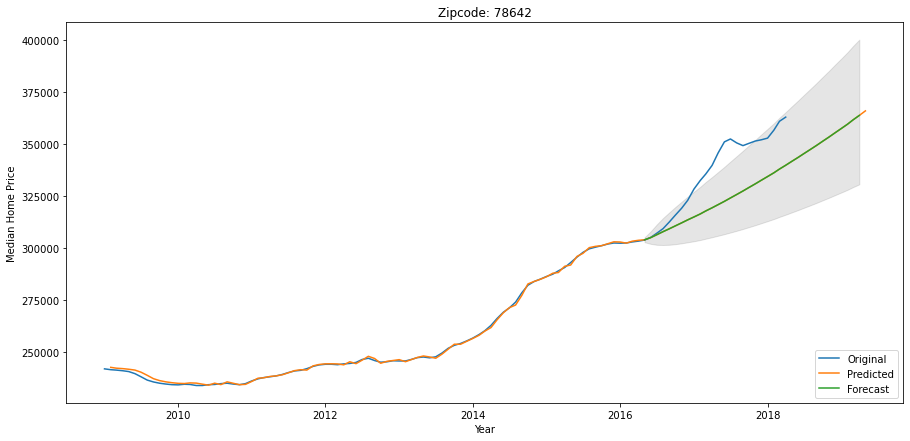

Zipcode: 78642
Explained Variance:
	 0.9621235800590056
MAE:
	 3761.701732698908
RMSE:
	 8380.809531990219
r^2:
	 0.9558252357276095


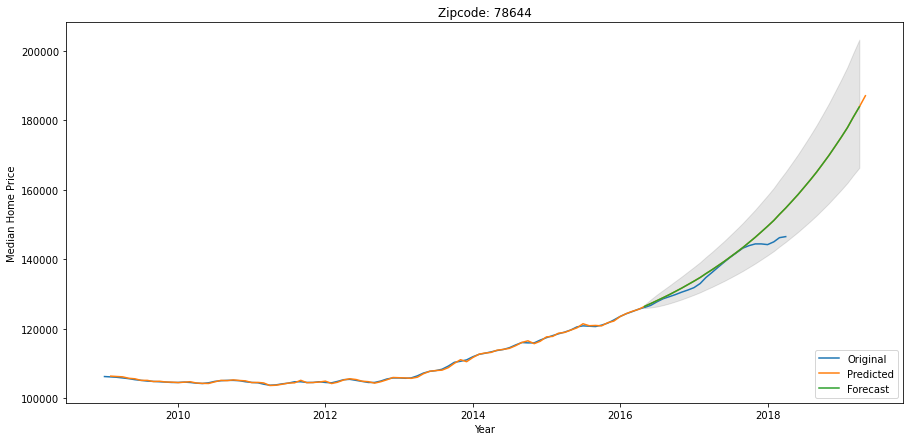

Zipcode: 78644
Explained Variance:
	 0.9896140865752799
MAE:
	 539.3145915474637
RMSE:
	 1387.1319092340605
r^2:
	 0.9886267221362792


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



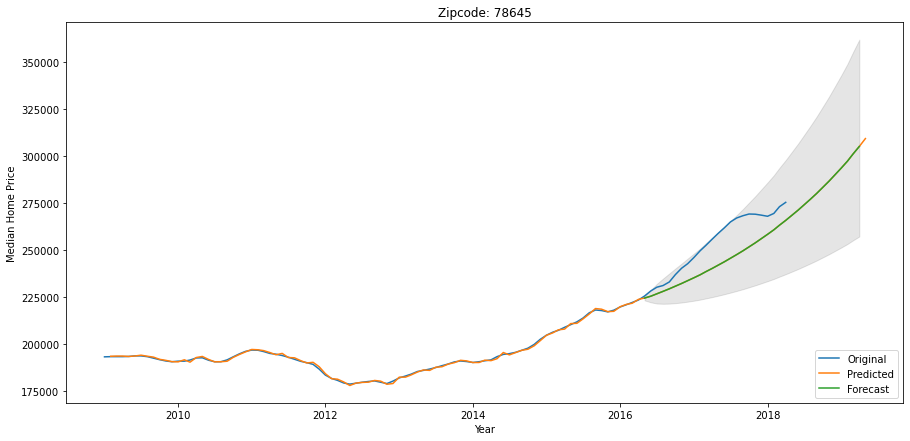

Zipcode: 78645
Explained Variance:
	 0.9624437179311781
MAE:
	 2738.5875326043815
RMSE:
	 5796.855643922227
r^2:
	 0.9547668530171186


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



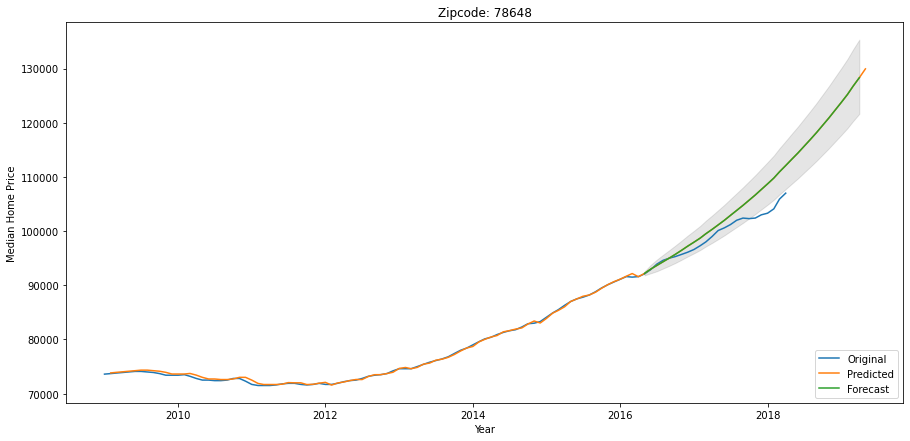

Zipcode: 78648
Explained Variance:
	 0.9871729283437176
MAE:
	 589.0330372111006
RMSE:
	 1322.0060124071133
r^2:
	 0.9848640656001144


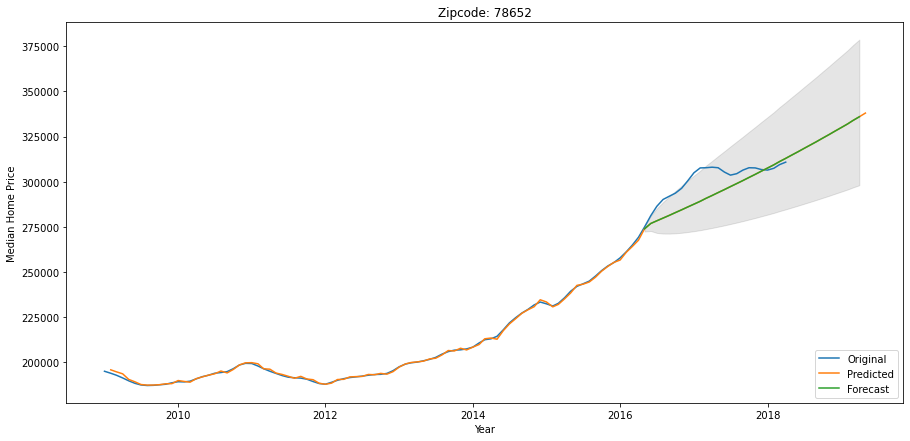

Zipcode: 78652
Explained Variance:
	 0.9897942347914457
MAE:
	 2197.985052169413
RMSE:
	 4687.861733602619
r^2:
	 0.9884039022375228


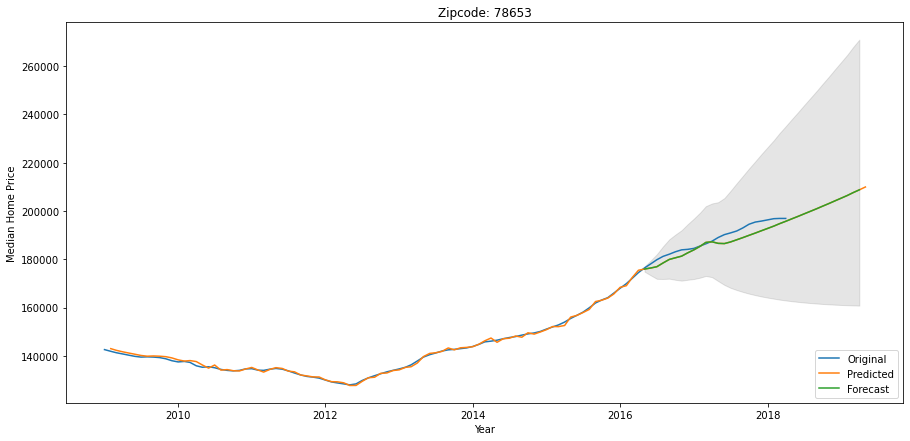

Zipcode: 78653
Explained Variance:
	 0.9961392029507878
MAE:
	 894.0937653318456
RMSE:
	 1404.8070118178248
r^2:
	 0.9957739549410888


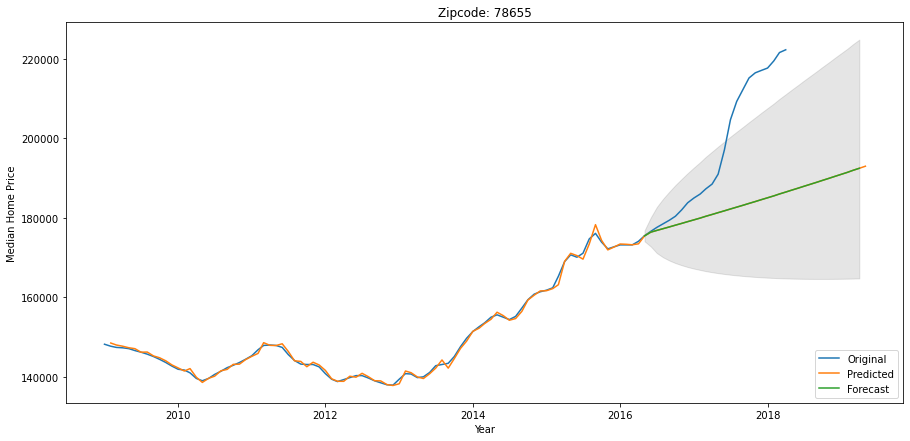

Zipcode: 78655
Explained Variance:
	 0.8452840691965622
MAE:
	 3766.433791273332
RMSE:
	 9730.95536607875
r^2:
	 0.8238773745635375


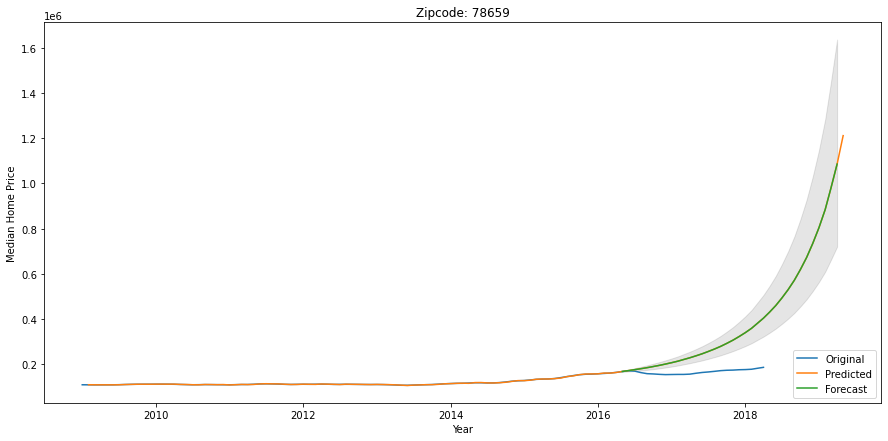

Zipcode: 78659
Explained Variance:
	 -2.5084125637767416
MAE:
	 18704.138655730698
RMSE:
	 48768.01070483351
r^2:
	 -3.087515240190819


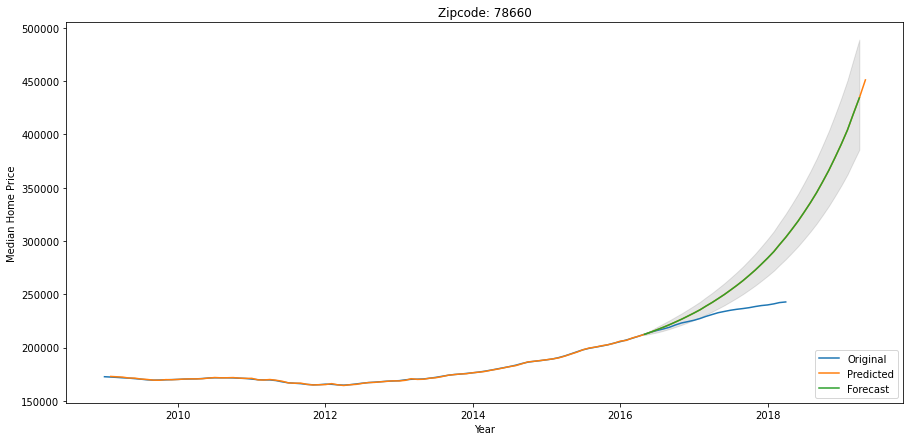

Zipcode: 78660
Explained Variance:
	 0.7793406678968033
MAE:
	 4301.067472652781
RMSE:
	 12348.473122898462
r^2:
	 0.7511785672839237


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



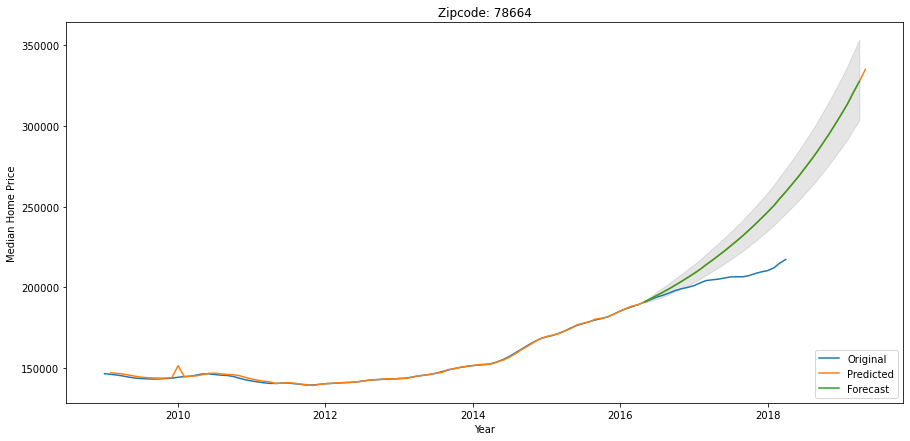

Zipcode: 78664
Explained Variance:
	 0.8573243383420315
MAE:
	 3996.66808829704
RMSE:
	 10167.42486770552
r^2:
	 0.833117549088542


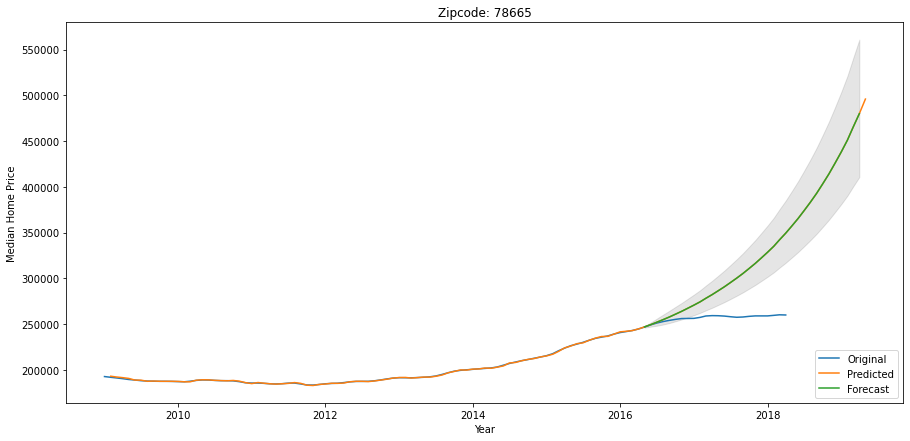

Zipcode: 78665
Explained Variance:
	 0.5677902794655894
MAE:
	 7290.189799434086
RMSE:
	 19951.1664964364
r^2:
	 0.5056605350016594


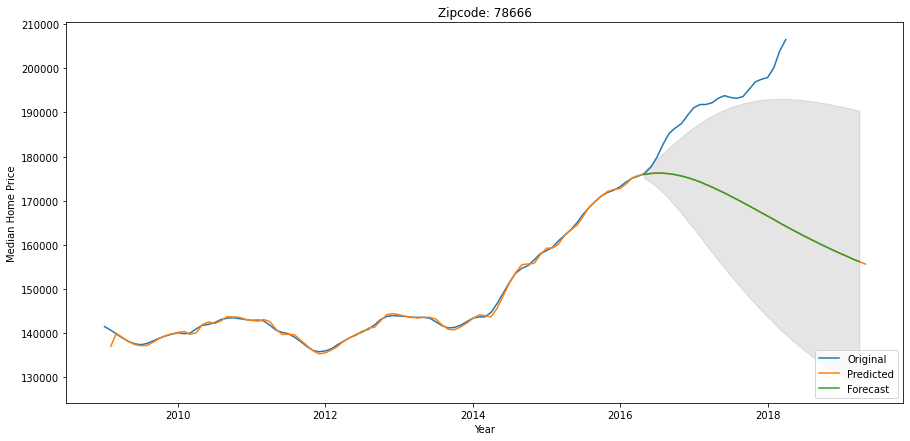

Zipcode: 78666
Explained Variance:
	 0.7927427532688085
MAE:
	 4528.79572123829
RMSE:
	 10525.341969919456
r^2:
	 0.750549051460698


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



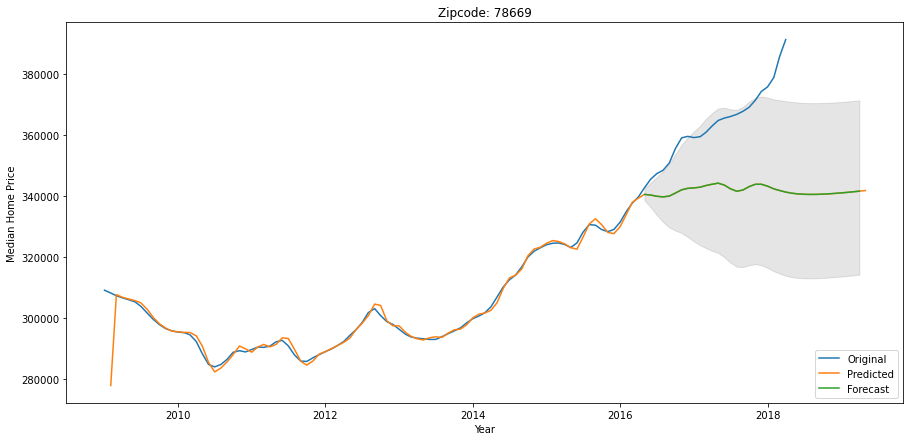

Zipcode: 78669
Explained Variance:
	 0.8627731370212457
MAE:
	 5494.919114072429
RMSE:
	 11700.696855104774
r^2:
	 0.8347280949557006


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



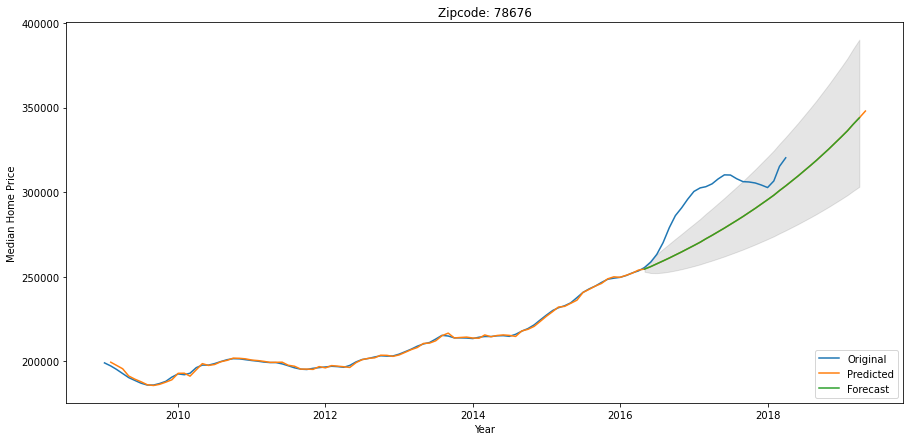

Zipcode: 78676
Explained Variance:
	 0.9451414823205969
MAE:
	 4687.542719926333
RMSE:
	 10255.98128871519
r^2:
	 0.9341079312755652


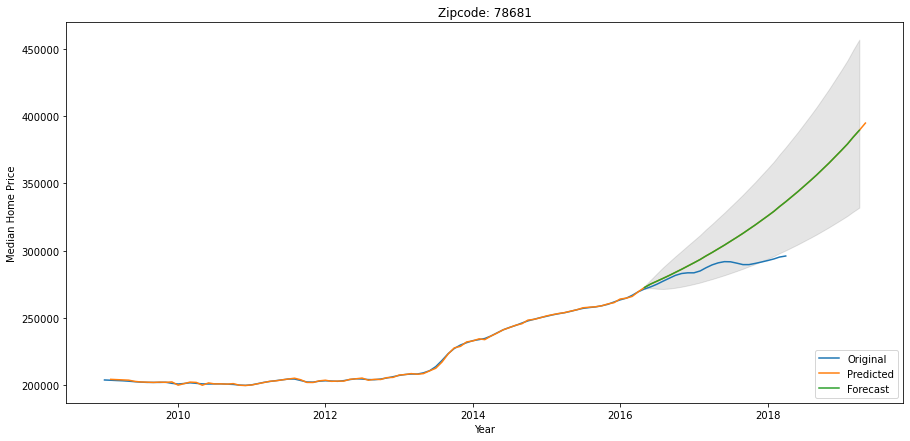

Zipcode: 78681
Explained Variance:
	 0.935291467752444
MAE:
	 3562.5991249541744
RMSE:
	 9297.62028298672
r^2:
	 0.9258047391452862


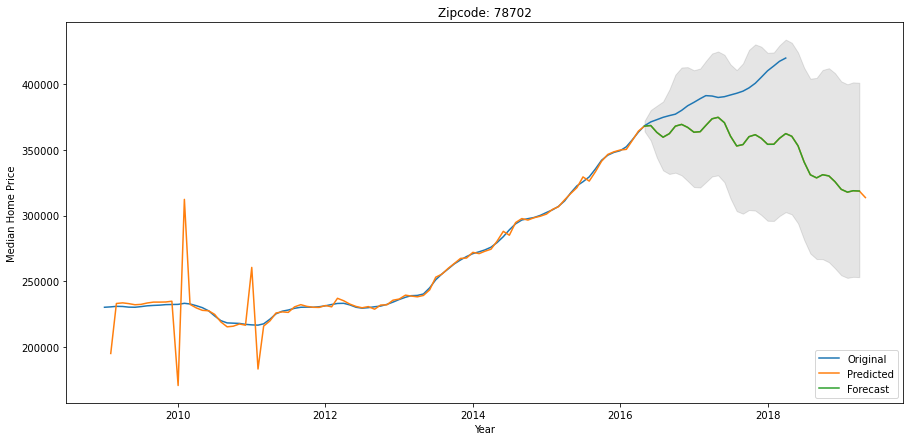

Zipcode: 78702
Explained Variance:
	 0.9240704906794809
MAE:
	 9265.172971903736
RMSE:
	 19183.967188613646
r^2:
	 0.9159218316280229


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



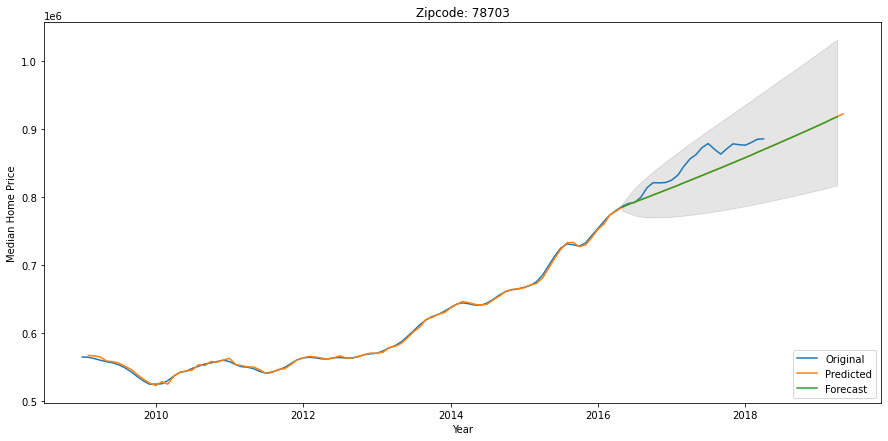

Zipcode: 78703
Explained Variance:
	 0.993163273300808
MAE:
	 5446.243814208315
RMSE:
	 10586.542309435023
r^2:
	 0.9919374339996623


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



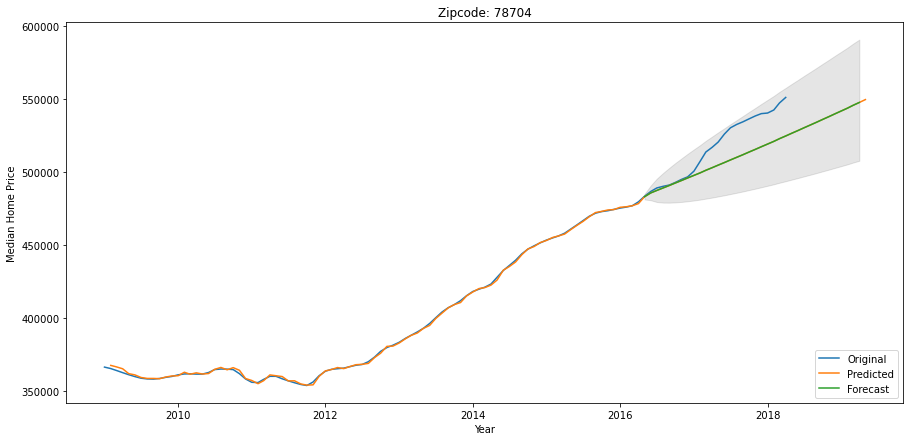

Zipcode: 78704
Explained Variance:
	 0.9873744274194257
MAE:
	 3272.0408206971406
RMSE:
	 7585.304346772037
r^2:
	 0.9854849909054267


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



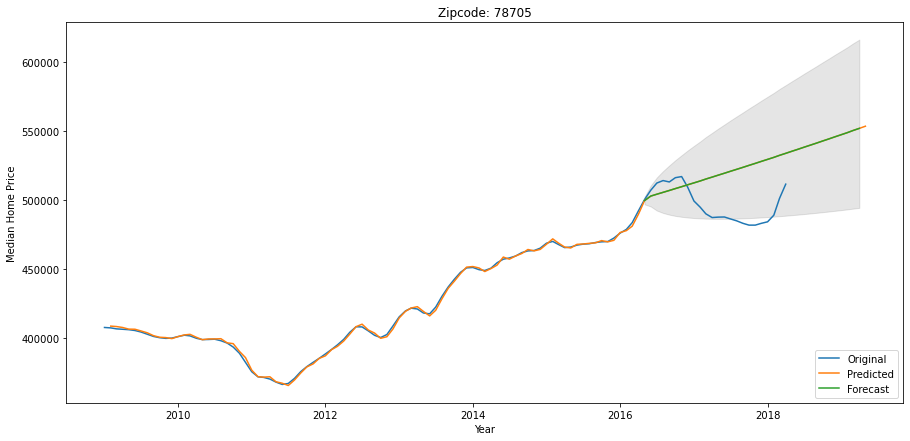

Zipcode: 78705
Explained Variance:
	 0.9179854727842124
MAE:
	 5963.310728930683
RMSE:
	 13360.288978914481
r^2:
	 0.9076232648642198


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



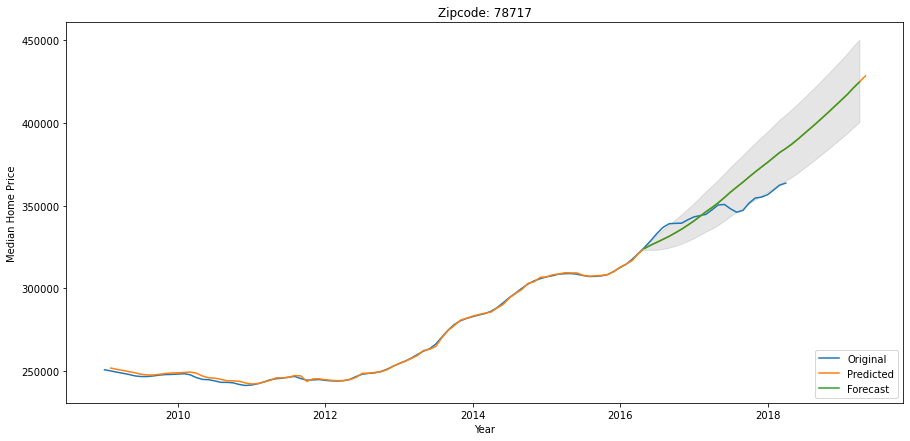

Zipcode: 78717
Explained Variance:
	 0.9829971117594172
MAE:
	 2476.7683077050033
RMSE:
	 5481.871192532037
r^2:
	 0.9814618804701707


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



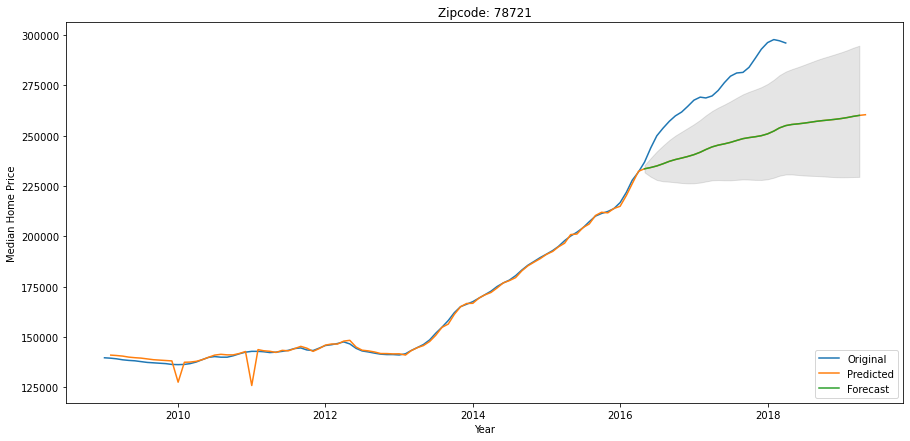

Zipcode: 78721
Explained Variance:
	 0.9395400568743469
MAE:
	 6983.417860086503
RMSE:
	 14420.029116540352
r^2:
	 0.9252696264701068


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



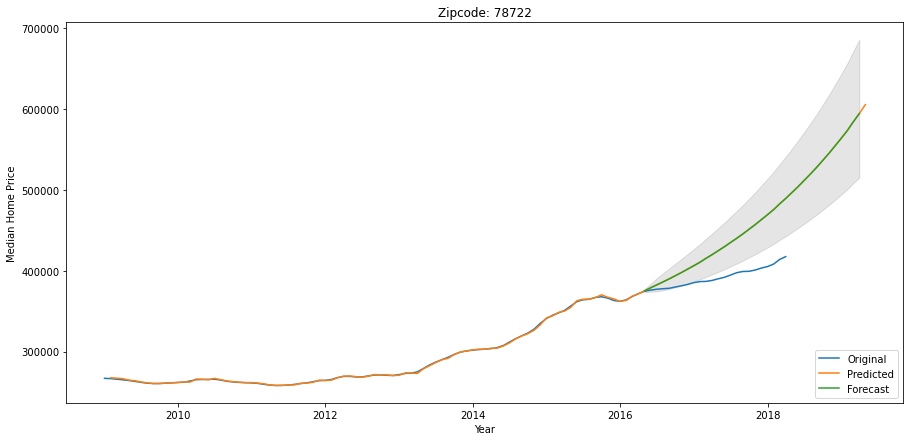

Zipcode: 78722
Explained Variance:
	 0.8917276696635009
MAE:
	 7905.939276788284
RMSE:
	 19050.596964620807
r^2:
	 0.8720269519326687


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



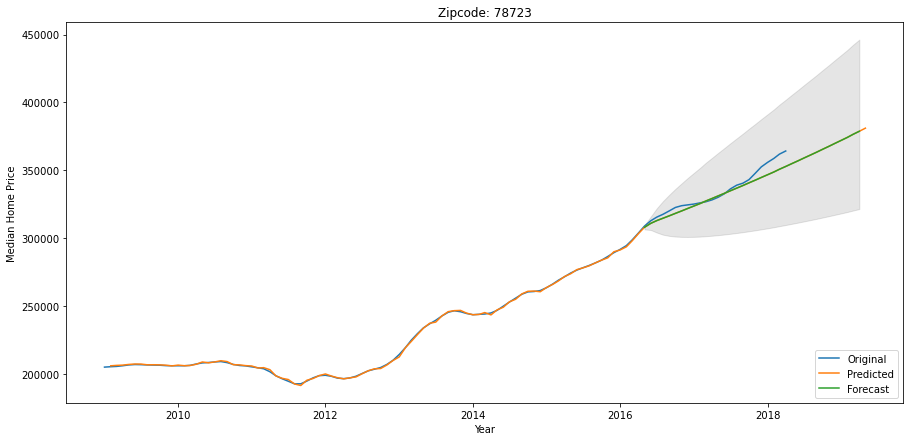

Zipcode: 78723
Explained Variance:
	 0.9980552177147862
MAE:
	 1164.5462971745949
RMSE:
	 2416.064766938784
r^2:
	 0.9978517632126699


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



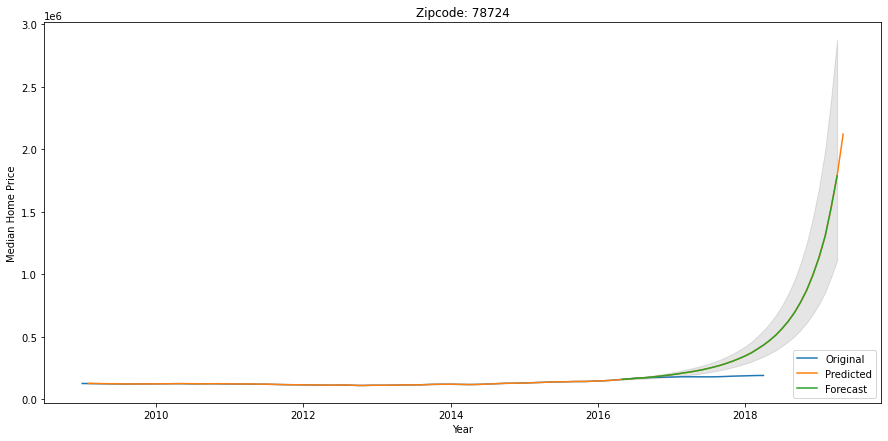

Zipcode: 78724
Explained Variance:
	 -2.159787679055567
MAE:
	 15243.861643620656
RMSE:
	 46178.81827266607
r^2:
	 -2.5332842690088215


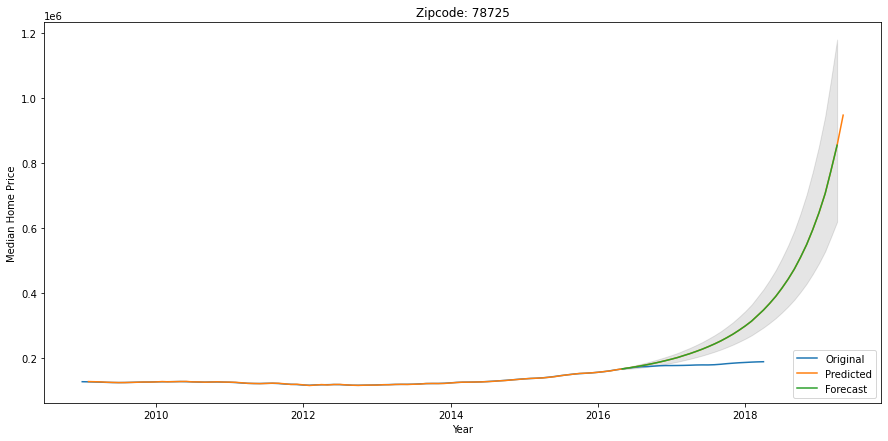

Zipcode: 78725
Explained Variance:
	 -0.7233216586706552
MAE:
	 11474.572856782466
RMSE:
	 32660.275248299942
r^2:
	 -0.9550343435415405


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



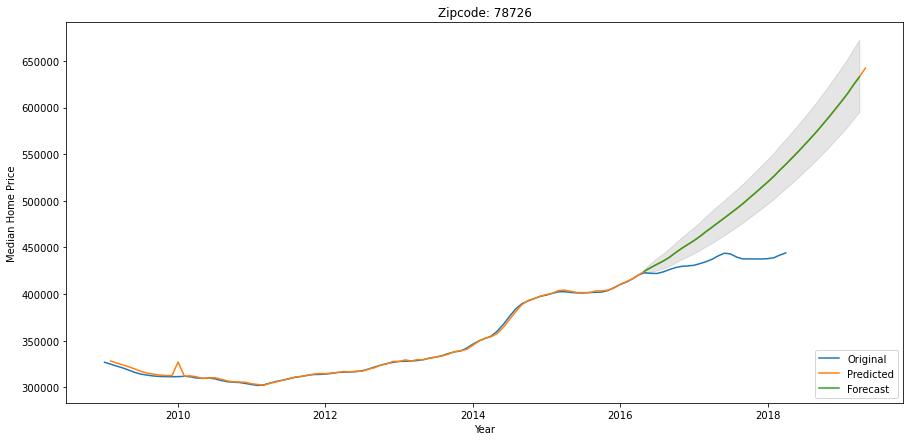

Zipcode: 78726
Explained Variance:
	 0.8157898959078725
MAE:
	 10042.047218466341
RMSE:
	 23889.503636903162
r^2:
	 0.7799307464805483


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



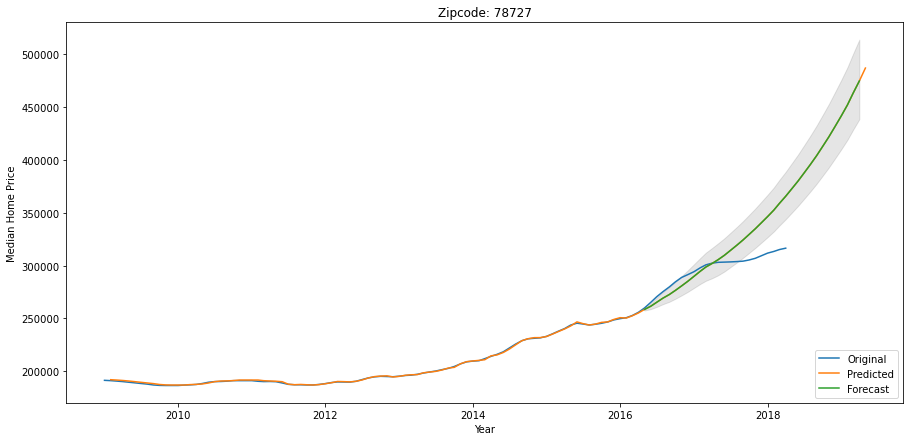

Zipcode: 78727
Explained Variance:
	 0.9507984618809786
MAE:
	 3604.9130902820784
RMSE:
	 9754.006023374743
r^2:
	 0.9476469047701033


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



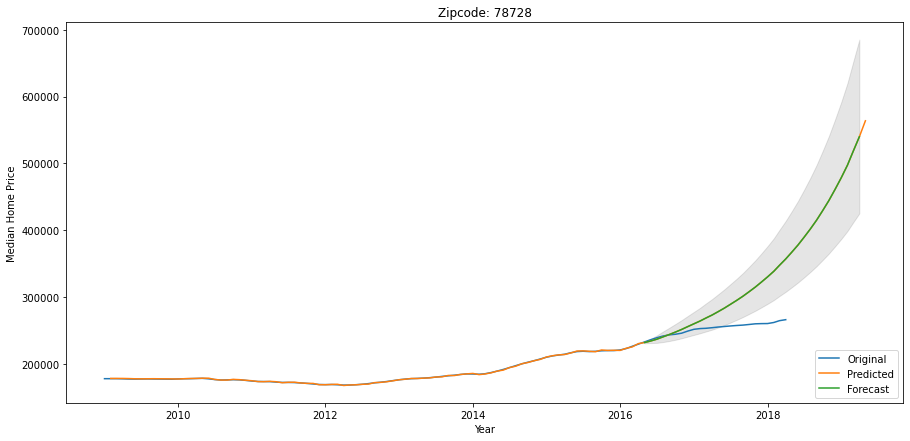

Zipcode: 78728
Explained Variance:
	 0.669425230040902
MAE:
	 6819.216460215423
RMSE:
	 19347.81819139854
r^2:
	 0.6276888780731358


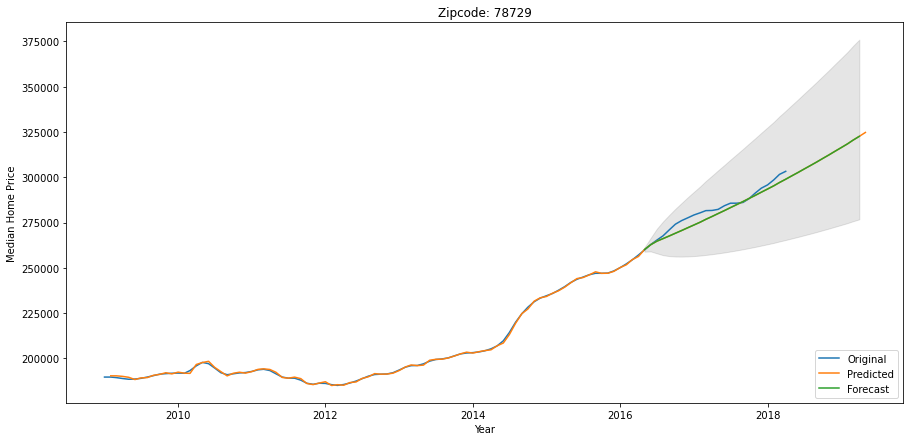

Zipcode: 78729
Explained Variance:
	 0.998333027384821
MAE:
	 910.6269467212587
RMSE:
	 1629.2222157907752
r^2:
	 0.9981077318962052


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



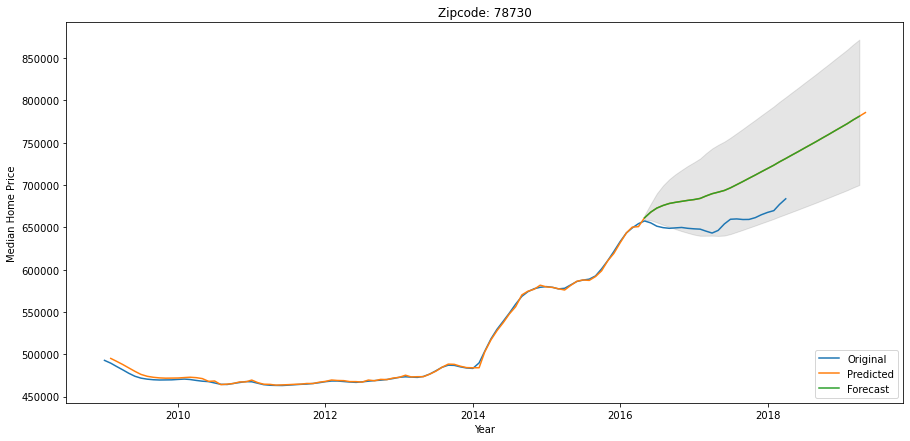

Zipcode: 78730
Explained Variance:
	 0.9572567163968072
MAE:
	 9303.464732106726
RMSE:
	 18607.249216172993
r^2:
	 0.9452712860605071


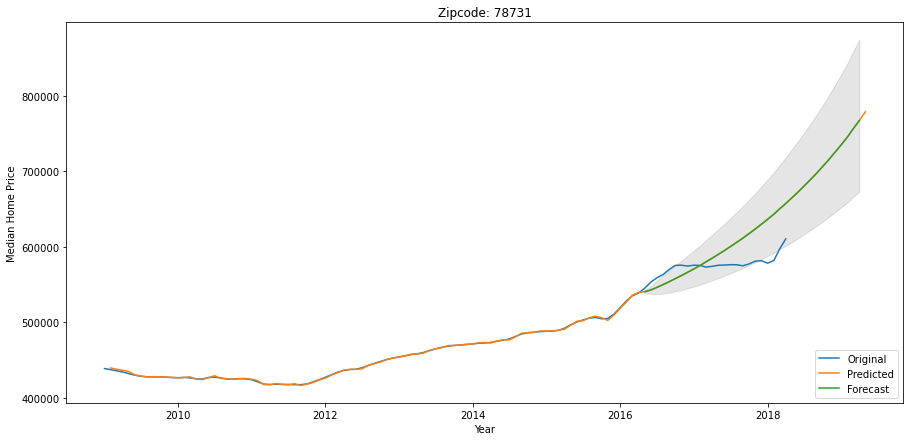

Zipcode: 78731
Explained Variance:
	 0.9414479211355682
MAE:
	 5877.190049596787
RMSE:
	 14342.879765809948
r^2:
	 0.9375260096574872


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



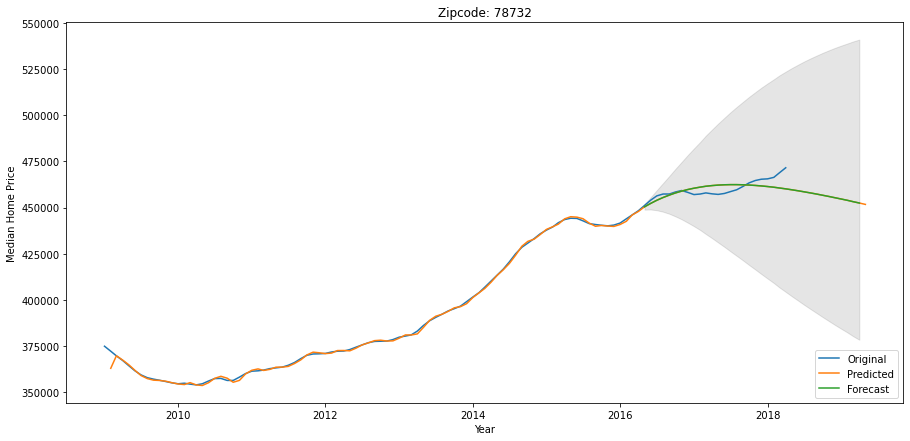

Zipcode: 78732
Explained Variance:
	 0.9971371937891069
MAE:
	 1187.2910448299533
RMSE:
	 2185.035813232703
r^2:
	 0.9970929490165237


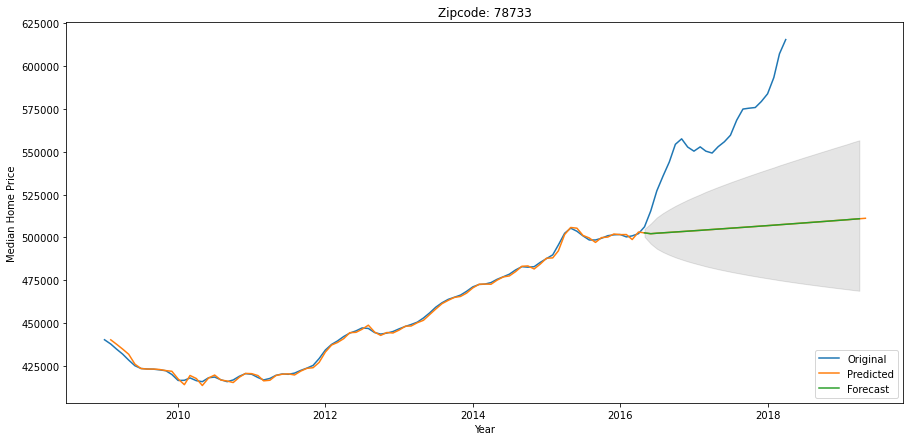

Zipcode: 78733
Explained Variance:
	 0.7769815393122069
MAE:
	 12648.330175801319
RMSE:
	 27977.022458165447
r^2:
	 0.7261231073297836


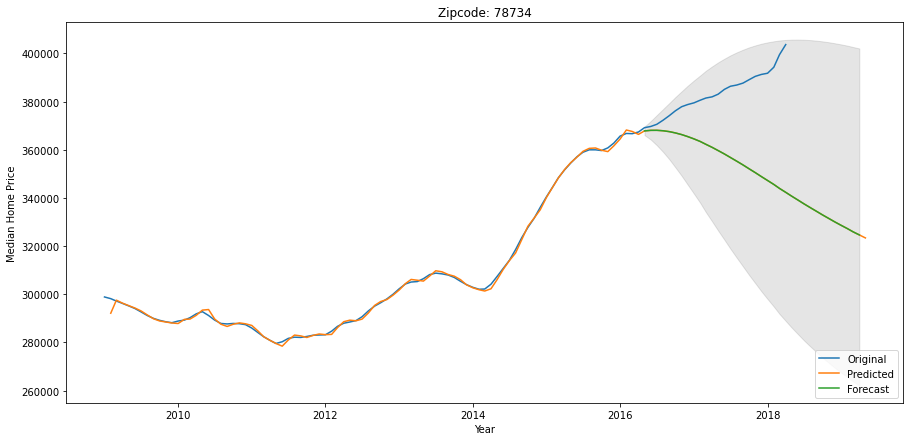

Zipcode: 78734
Explained Variance:
	 0.8906591554995621
MAE:
	 5887.299732933471
RMSE:
	 14121.930075629953
r^2:
	 0.8711943056087557


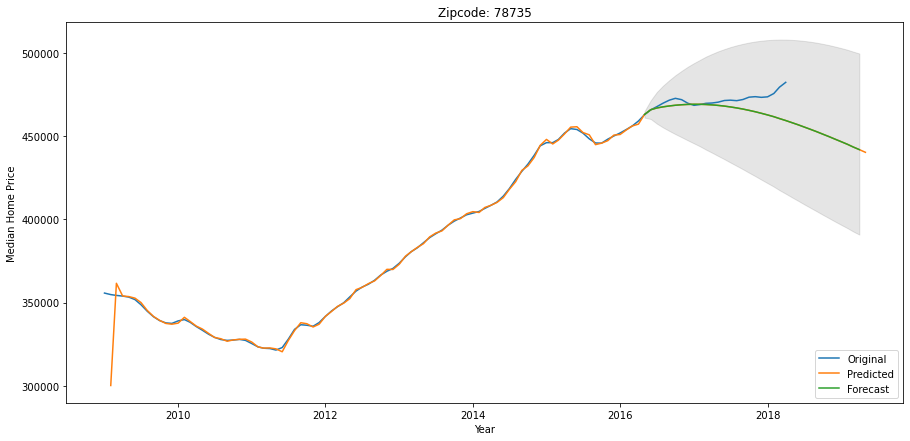

Zipcode: 78735
Explained Variance:
	 0.9872936649250735
MAE:
	 2208.1804326892725
RMSE:
	 6470.477295248765
r^2:
	 0.9865092354166275


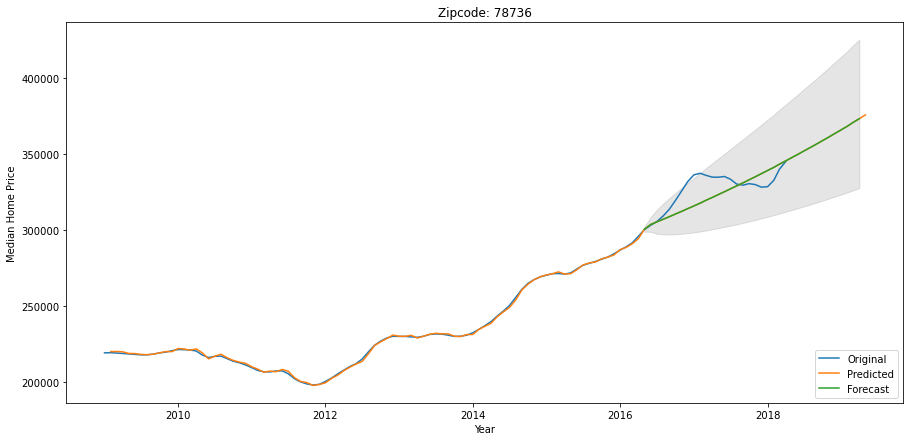

Zipcode: 78736
Explained Variance:
	 0.9896651522391893
MAE:
	 2116.365560505448
RMSE:
	 4723.266566635718
r^2:
	 0.9892604716195046


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



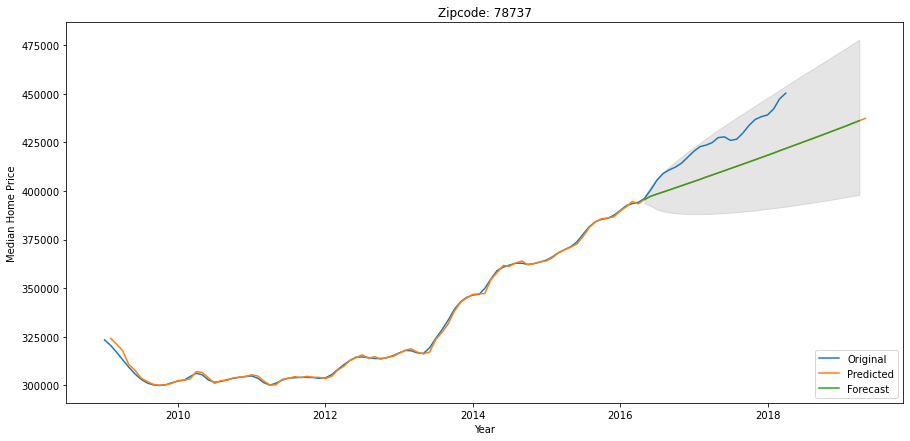

Zipcode: 78737
Explained Variance:
	 0.9776990621304261
MAE:
	 3908.185753329456
RMSE:
	 7868.5766718582645
r^2:
	 0.97302021009588


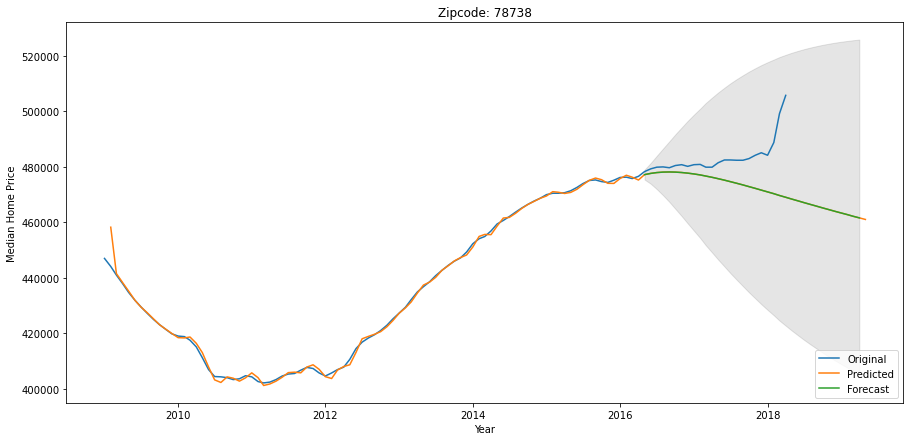

Zipcode: 78738
Explained Variance:
	 0.9666872676683278
MAE:
	 2424.4922289577707
RMSE:
	 5847.871258817419
r^2:
	 0.963427428709607


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



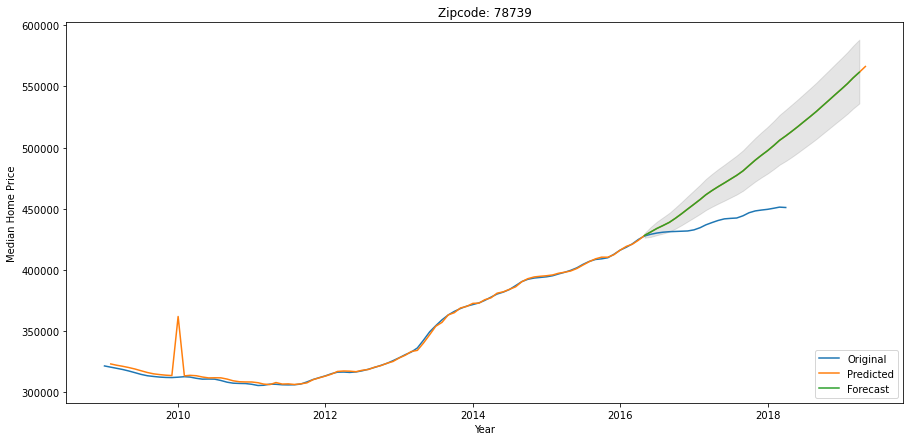

Zipcode: 78739
Explained Variance:
	 0.9267124805406264
MAE:
	 7124.934319979073
RMSE:
	 15712.192987443143
r^2:
	 0.9099432481950296


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



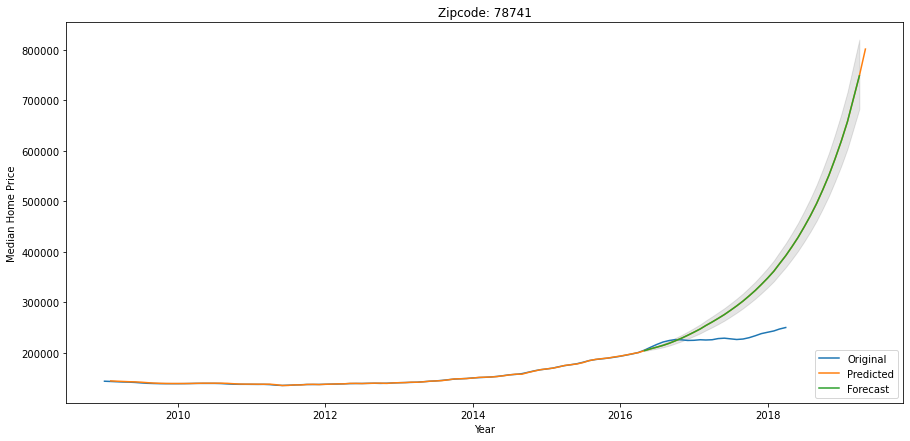

Zipcode: 78741
Explained Variance:
	 0.34367087220130166
MAE:
	 11016.548584378614
RMSE:
	 31002.17147376745
r^2:
	 0.25960045215713345


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



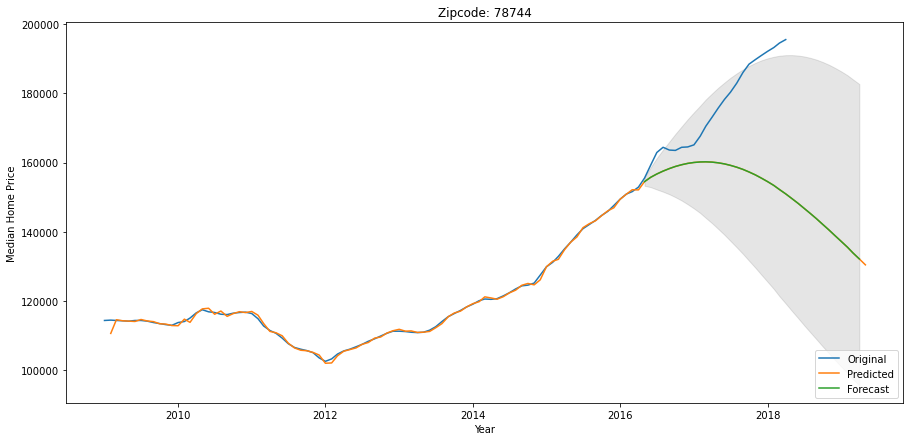

Zipcode: 78744
Explained Variance:
	 0.8563772901794833
MAE:
	 4306.174578035501
RMSE:
	 10863.20320026526
r^2:
	 0.8329622936996768


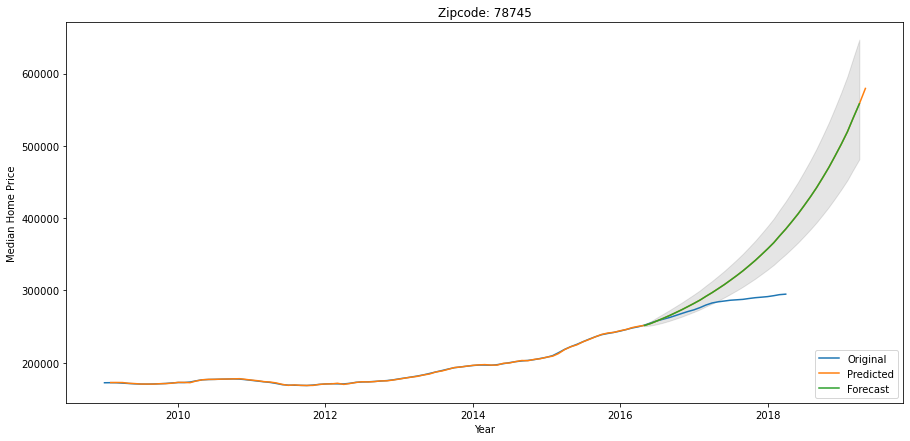

Zipcode: 78745
Explained Variance:
	 0.8326373786242651
MAE:
	 6321.332832936084
RMSE:
	 18387.8449508503
r^2:
	 0.8122521581832522


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



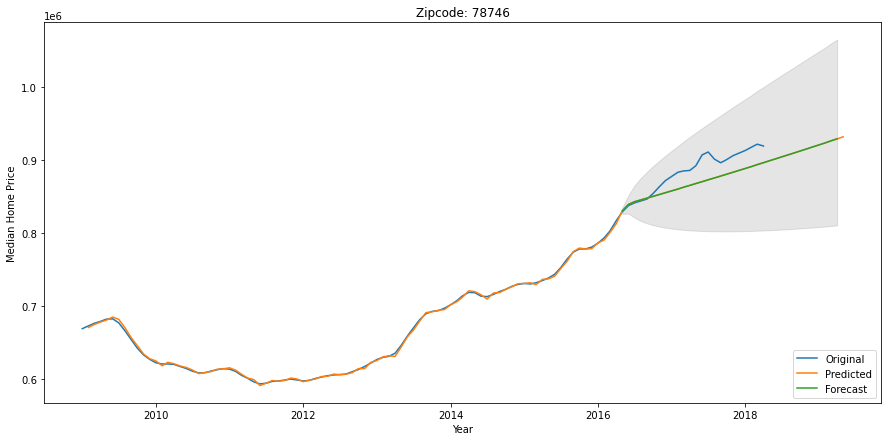

Zipcode: 78746
Explained Variance:
	 0.9924690696084062
MAE:
	 5102.490253094705
RMSE:
	 9964.663968708144
r^2:
	 0.9911663397054857


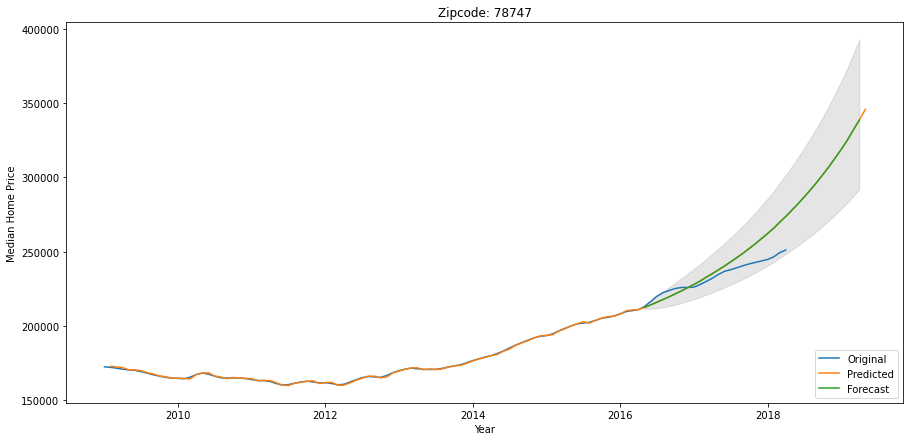

Zipcode: 78747
Explained Variance:
	 0.9738645321219349
MAE:
	 1853.058928227212
RMSE:
	 4623.195422095516
r^2:
	 0.9719361239210454


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



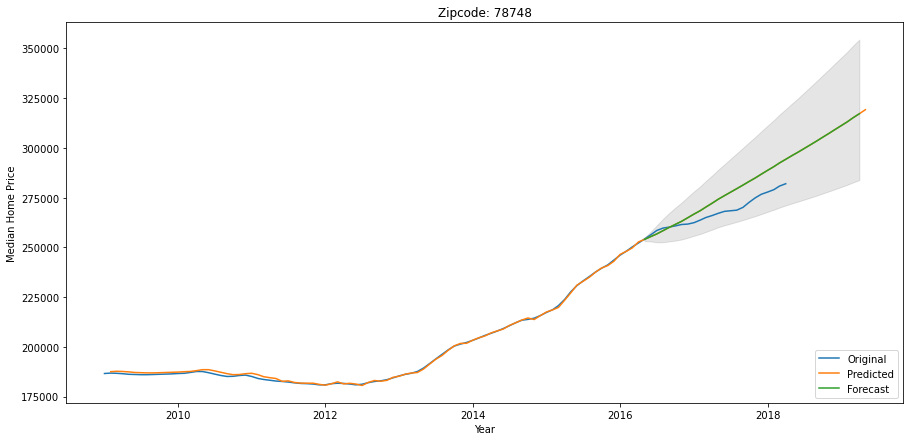

Zipcode: 78748
Explained Variance:
	 0.9905892099657501
MAE:
	 1800.5597173745452
RMSE:
	 3625.639781432146
r^2:
	 0.9884835116545135


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



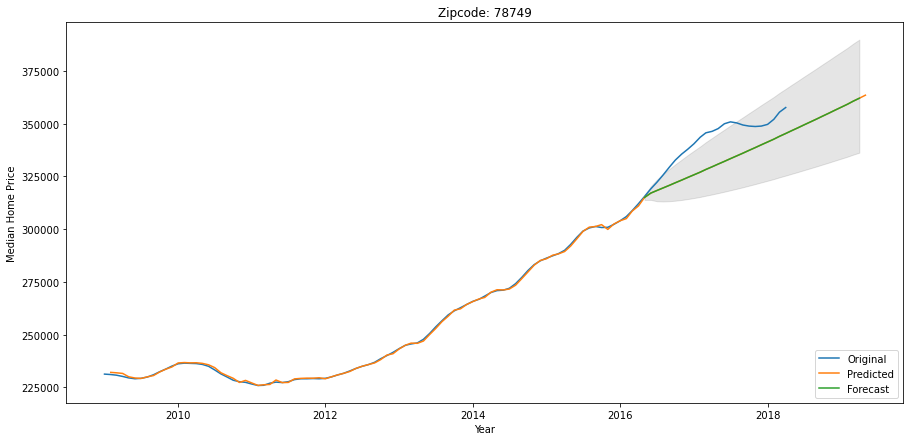

Zipcode: 78749
Explained Variance:
	 0.9857041636814801
MAE:
	 2810.629578483725
RMSE:
	 5817.529586692427
r^2:
	 0.9825487890766847


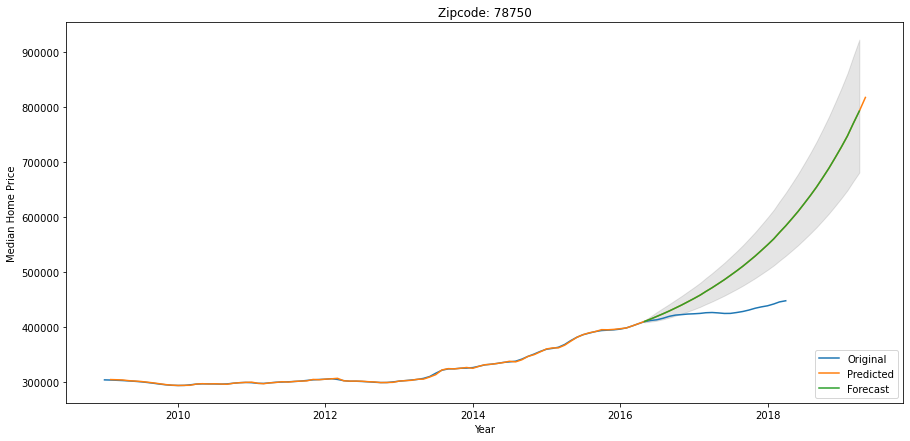

Zipcode: 78750
Explained Variance:
	 0.6631566357279303
MAE:
	 12486.092132535015
RMSE:
	 32628.670869241952
r^2:
	 0.6094133908856029


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



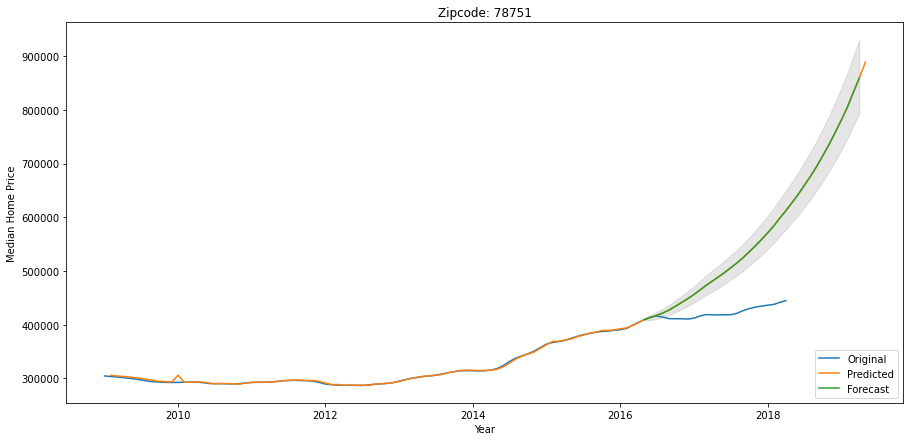

Zipcode: 78751
Explained Variance:
	 0.5107302480422948
MAE:
	 16158.254967072946
RMSE:
	 40610.58571461355
r^2:
	 0.4247662679049814


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



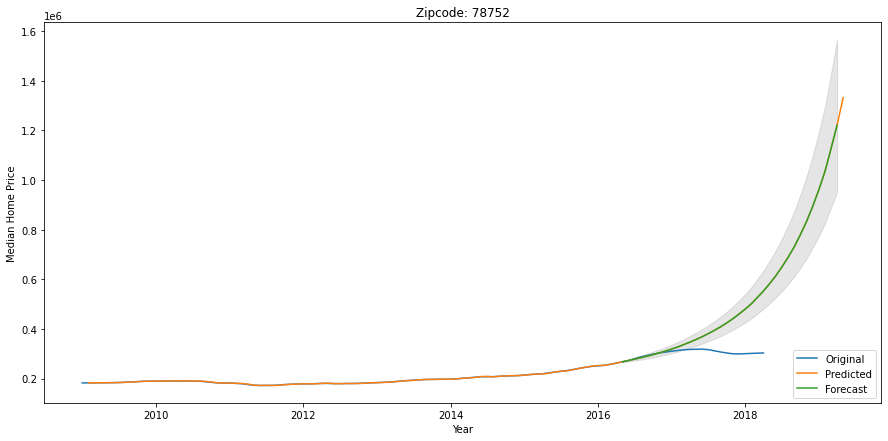

Zipcode: 78752
Explained Variance:
	 0.026277507437870495
MAE:
	 15649.997734998984
RMSE:
	 49584.111724666305
r^2:
	 -0.0744372232635675


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



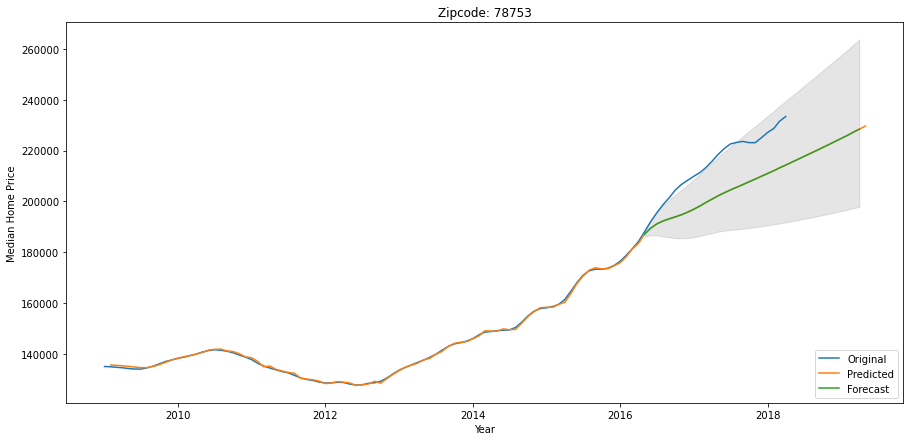

Zipcode: 78753
Explained Variance:
	 0.9668053182630888
MAE:
	 3088.307962984777
RMSE:
	 6524.824451796157
r^2:
	 0.9593095864415082


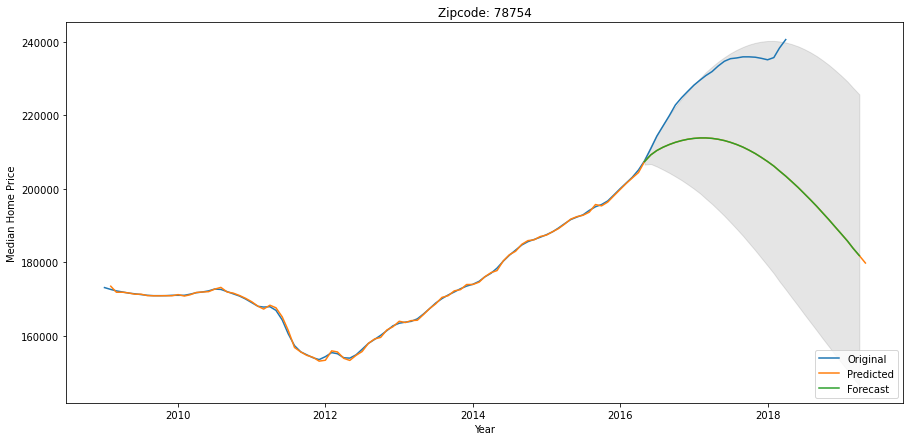

Zipcode: 78754
Explained Variance:
	 0.885539868391898
MAE:
	 4156.733009441565
RMSE:
	 9656.092239472748
r^2:
	 0.8623105077241939


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



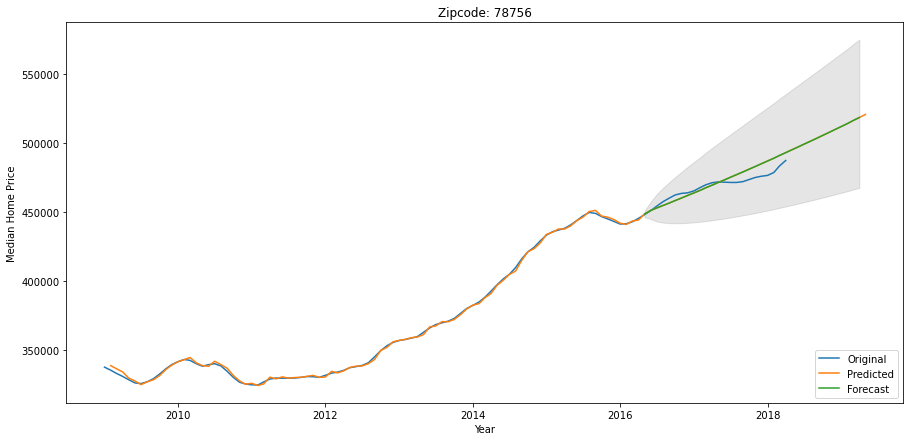

Zipcode: 78756
Explained Variance:
	 0.9978686126850304
MAE:
	 1594.8388908650252
RMSE:
	 2658.593285875239
r^2:
	 0.9977788172858107


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



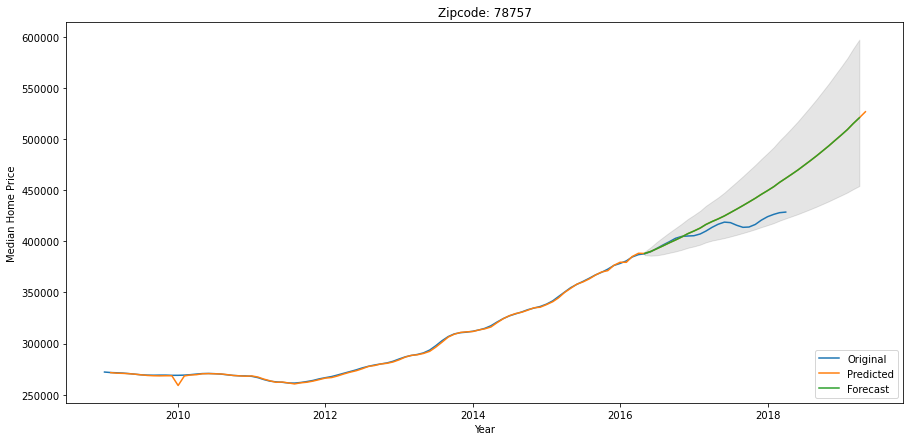

Zipcode: 78757
Explained Variance:
	 0.9837939686206985
MAE:
	 2982.6829337706263
RMSE:
	 7579.936111867399
r^2:
	 0.9824686759541454


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



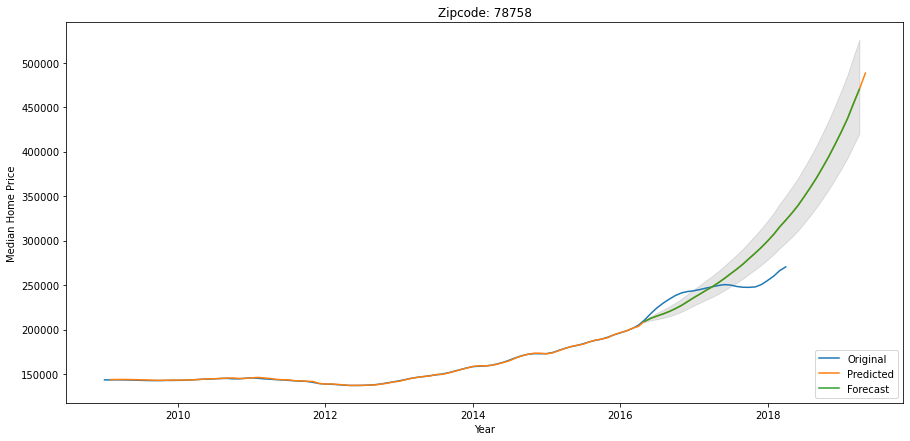

Zipcode: 78758
Explained Variance:
	 0.9176253356985964
MAE:
	 4482.78444557894
RMSE:
	 11980.152734074394
r^2:
	 0.9136908501664411


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



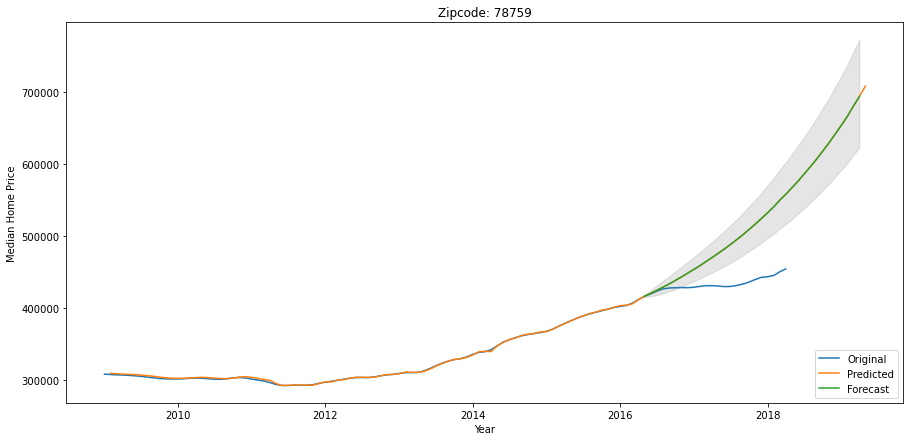

Zipcode: 78759
Explained Variance:
	 0.7953271107890485
MAE:
	 10428.20303528909
RMSE:
	 26467.324228507583
r^2:
	 0.7599696587051974


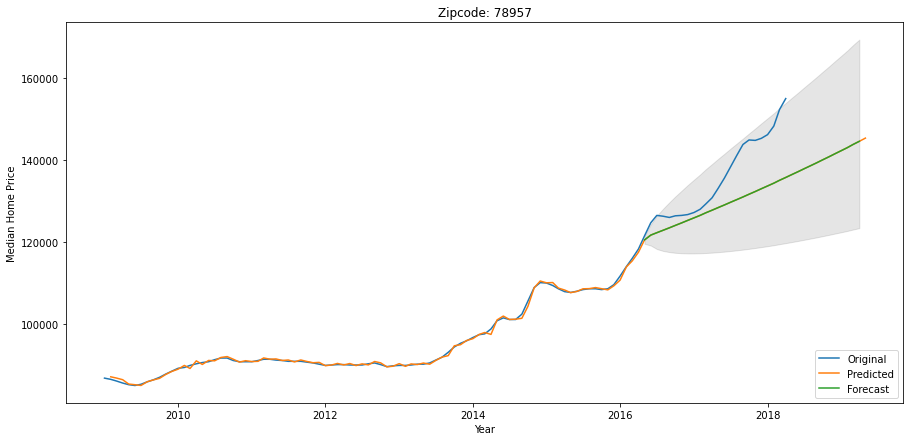

Zipcode: 78957
Explained Variance:
	 0.9549819319366563
MAE:
	 1786.888188348086
RMSE:
	 4254.014489441386
r^2:
	 0.9482033419872122


In [128]:
cutoff = '2016-04-01'
var_dict = {}
for zipcode in df_final.columns:
    # Train-test split
    train = df_final[zipcode][:cutoff]

    test = df_final[zipcode][cutoff:]
    
    original_series, prediction_series, forecast = run_arima_model(train, 0, 124)
    
    fig, ax = plt.subplots(figsize=(15, 7))
    plt.plot(df_final[zipcode])
    plt.plot(prediction_series[1:])
    plt.plot(forecast['mean'])
    ax.fill_between(forecast.index, forecast['mean_ci_lower'], forecast['mean_ci_upper'], color='k', alpha=0.1);
    plt.title(f'Zipcode: {zipcode}')
    plt.legend(['Original','Predicted', 'Forecast'], loc='lower right')
    plt.xlabel('Year')
    plt.ylabel('Median Home Price')
    plt.show()
    
    print(f'Zipcode: {zipcode}')
    report_metrics(df_final[zipcode][1:], prediction_series[1:-13]) 
    
    var_dict[zipcode] = metrics.explained_variance_score(df_final[zipcode][1:], prediction_series[1:-13])

In [129]:
var_dict

{76530: 0.909162232267951,
 76574: 0.9194801886838533,
 78602: 0.25091503949421345,
 78610: 0.8878648178483416,
 78612: 0.738420557541072,
 78613: 0.9915310447429279,
 78616: 0.968871596928736,
 78617: 0.9407262043096282,
 78619: 0.947697354049903,
 78620: 0.9957180766469141,
 78621: 0.8892992738933012,
 78626: 0.9949889421653906,
 78628: 0.7661811192456791,
 78633: 0.995183446371585,
 78634: 0.9966736969174443,
 78640: 0.8649534440877593,
 78641: 0.849460503780418,
 78642: 0.9621235800590056,
 78644: 0.9896140865752799,
 78645: 0.9624437179311781,
 78648: 0.9871729283437176,
 78652: 0.9897942347914457,
 78653: 0.9961392029507878,
 78655: 0.8452840691965622,
 78659: -2.5084125637767416,
 78660: 0.7793406678968033,
 78664: 0.8573243383420315,
 78665: 0.5677902794655894,
 78666: 0.7927427532688085,
 78669: 0.8627731370212457,
 78676: 0.9451414823205969,
 78681: 0.935291467752444,
 78702: 0.9240704906794809,
 78703: 0.993163273300808,
 78704: 0.9873744274194257,
 78705: 0.9179854727842124

In [46]:
var_dict = {76530: 0.909162232267951,
 76574: 0.9194801886838533,
 78602: 0.25091503949421345,
 78610: 0.8878648178483416,
 78612: 0.738420557541072,
 78613: 0.9915310447429279,
 78616: 0.968871596928736,
 78617: 0.9407262043096282,
 78619: 0.947697354049903,
 78620: 0.9957180766469141,
 78621: 0.8892992738933012,
 78626: 0.9949889421653906,
 78628: 0.7661811192456791,
 78633: 0.995183446371585,
 78634: 0.9966736969174443,
 78640: 0.8649534440877593,
 78641: 0.849460503780418,
 78642: 0.9621235800590056,
 78644: 0.9896140865752799,
 78645: 0.9624437179311781,
 78648: 0.9871729283437176,
 78652: 0.9897942347914457,
 78653: 0.9961392029507878,
 78655: 0.8452840691965622,
 78659: -2.5084125637767416,
 78660: 0.7793406678968033,
 78664: 0.8573243383420315,
 78665: 0.5677902794655894,
 78666: 0.7927427532688085,
 78669: 0.8627731370212457,
 78676: 0.9451414823205969,
 78681: 0.935291467752444,
 78702: 0.9240704906794809,
 78703: 0.993163273300808,
 78704: 0.9873744274194257,
 78705: 0.9179854727842124,
 78717: 0.9829971117594172,
 78721: 0.9395400568743469,
 78722: 0.8917276696635009,
 78723: 0.9980552177147862,
 78724: -2.159787679055567,
 78725: -0.7233216586706552,
 78726: 0.8157898959078725,
 78727: 0.9507984618809786,
 78728: 0.669425230040902,
 78729: 0.998333027384821,
 78730: 0.9572567163968072,
 78731: 0.9414479211355682,
 78732: 0.9971371937891069,
 78733: 0.7769815393122069,
 78734: 0.8906591554995621,
 78735: 0.9872936649250735,
 78736: 0.9896651522391893,
 78737: 0.9776990621304261,
 78738: 0.9666872676683278,
 78739: 0.9267124805406264,
 78741: 0.34367087220130166,
 78744: 0.8563772901794833,
 78745: 0.8326373786242651,
 78746: 0.9924690696084062,
 78747: 0.9738645321219349,
 78748: 0.9905892099657501,
 78749: 0.9857041636814801,
 78750: 0.6631566357279303,
 78751: 0.5107302480422948,
 78752: 0.026277507437870495,
 78753: 0.9668053182630888,
 78754: 0.885539868391898,
 78756: 0.9978686126850304,
 78757: 0.9837939686206985,
 78758: 0.9176253356985964,
 78759: 0.7953271107890485,
 78957: 0.9549819319366563}

- We will choose 99% explained variance of the zipcodes to move on.

In [54]:
top_zipcodes = []
for (key, value) in var_dict.items():
    if value > 0.99:
        top_zipcodes.append(key)

In [55]:
top_zipcodes

[78613,
 78620,
 78626,
 78633,
 78634,
 78653,
 78703,
 78723,
 78729,
 78732,
 78746,
 78748,
 78756]

In [61]:
cutoff = '2016-04-01'
predicted_return = {}
for zipcode in top_zipcodes:
    # Train-test split
    train = df_final[zipcode][:cutoff]

    test = df_final[zipcode][cutoff:]
    
    original_series, prediction_series, forecast = run_arima_model(train, 0, 124)

    
    print(f'Zipcode: {zipcode}')
    report_metrics(df_final[zipcode][1:], prediction_series[1:-13]) 
    
    
    predicted_return[zipcode] = (forecast['mean'][-1] - df_final[zipcode][-1])/df_final[zipcode][-1]
    print(f'Predicted return for {zipcode}: {predicted_return[zipcode]}')
    

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Zipcode: 78613
Explained Variance:
	 0.9915310447429279
MAE:
	 1748.9412593968468
RMSE:
	 3512.8853803611537
r^2:
	 0.9897036650385482
Predicted return for 78613: {78613: 0.021468135409514776}
Zipcode: 78620
Explained Variance:
	 0.9957180766469141
MAE:
	 1826.4580001981572
RMSE:
	 3580.8105124615745
r^2:
	 0.9950107303411814
Predicted return for 78620: {78613: 0.021468135409514776, 78620: 0.12344628479153447}


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Zipcode: 78626
Explained Variance:
	 0.9949889421653906
MAE:
	 1250.474702486909
RMSE:
	 2081.2778799402745
r^2:
	 0.9944182342202443
Predicted return for 78626: {78613: 0.021468135409514776, 78620: 0.12344628479153447, 78626: 0.07135729749211887}


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Zipcode: 78633
Explained Variance:
	 0.995183446371585
MAE:
	 1390.206309194526
RMSE:
	 2467.597406208425
r^2:
	 0.9951594065888638
Predicted return for 78633: {78613: 0.021468135409514776, 78620: 0.12344628479153447, 78626: 0.07135729749211887, 78633: 0.05230598327278752}
Zipcode: 78634
Explained Variance:
	 0.9966736969174443
MAE:
	 909.8635418934662
RMSE:
	 1431.3741584547913
r^2:
	 0.996606747605572
Predicted return for 78634: {78613: 0.021468135409514776, 78620: 0.12344628479153447, 78626: 0.07135729749211887, 78633: 0.05230598327278752, 78634: 0.0968215173439336}
Zipcode: 78653
Explained Variance:
	 0.9961392029507878
MAE:
	 894.0937653318456
RMSE:
	 1404.8070118178248
r^2:
	 0.9957739549410888
Predicted return for 78653: {78613: 0.021468135409514776, 78620: 0.12344628479153447, 78626: 0.07135729749211887, 78633: 0.05230598327278752, 78634: 0.0968215173439336, 78653: 0.060136232495097086}


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Zipcode: 78703
Explained Variance:
	 0.993163273300808
MAE:
	 5446.243814208315
RMSE:
	 10586.542309435023
r^2:
	 0.9919374339996623
Predicted return for 78703: {78613: 0.021468135409514776, 78620: 0.12344628479153447, 78626: 0.07135729749211887, 78633: 0.05230598327278752, 78634: 0.0968215173439336, 78653: 0.060136232495097086, 78703: 0.0366785163025791}


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Zipcode: 78723
Explained Variance:
	 0.9980552177147862
MAE:
	 1164.5462971745949
RMSE:
	 2416.064766938784
r^2:
	 0.9978517632126699
Predicted return for 78723: {78613: 0.021468135409514776, 78620: 0.12344628479153447, 78626: 0.07135729749211887, 78633: 0.05230598327278752, 78634: 0.0968215173439336, 78653: 0.060136232495097086, 78703: 0.0366785163025791, 78723: 0.03991543789837774}
Zipcode: 78729
Explained Variance:
	 0.998333027384821
MAE:
	 910.6269467212587
RMSE:
	 1629.2222157907752
r^2:
	 0.9981077318962052
Predicted return for 78729: {78613: 0.021468135409514776, 78620: 0.12344628479153447, 78626: 0.07135729749211887, 78633: 0.05230598327278752, 78634: 0.0968215173439336, 78653: 0.060136232495097086, 78703: 0.0366785163025791, 78723: 0.03991543789837774, 78729: 0.06374046882785143}


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Zipcode: 78732
Explained Variance:
	 0.9971371937891069
MAE:
	 1187.2910448299533
RMSE:
	 2185.035813232703
r^2:
	 0.9970929490165237
Predicted return for 78732: {78613: 0.021468135409514776, 78620: 0.12344628479153447, 78626: 0.07135729749211887, 78633: 0.05230598327278752, 78634: 0.0968215173439336, 78653: 0.060136232495097086, 78703: 0.0366785163025791, 78723: 0.03991543789837774, 78729: 0.06374046882785143, 78732: -0.0404432694547025}


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Zipcode: 78746
Explained Variance:
	 0.9924690696084062
MAE:
	 5102.490253094705
RMSE:
	 9964.663968708144
r^2:
	 0.9911663397054857
Predicted return for 78746: {78613: 0.021468135409514776, 78620: 0.12344628479153447, 78626: 0.07135729749211887, 78633: 0.05230598327278752, 78634: 0.0968215173439336, 78653: 0.060136232495097086, 78703: 0.0366785163025791, 78723: 0.03991543789837774, 78729: 0.06374046882785143, 78732: -0.0404432694547025, 78746: 0.010680070786624356}


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Zipcode: 78748
Explained Variance:
	 0.9905892099657501
MAE:
	 1800.5597173745452
RMSE:
	 3625.639781432146
r^2:
	 0.9884835116545135
Predicted return for 78748: {78613: 0.021468135409514776, 78620: 0.12344628479153447, 78626: 0.07135729749211887, 78633: 0.05230598327278752, 78634: 0.0968215173439336, 78653: 0.060136232495097086, 78703: 0.0366785163025791, 78723: 0.03991543789837774, 78729: 0.06374046882785143, 78732: -0.0404432694547025, 78746: 0.010680070786624356, 78748: 0.12475671903952293}


C:\Users\emine\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Zipcode: 78756
Explained Variance:
	 0.9978686126850304
MAE:
	 1594.8388908650252
RMSE:
	 2658.593285875239
r^2:
	 0.9977788172858107
Predicted return for 78756: {78613: 0.021468135409514776, 78620: 0.12344628479153447, 78626: 0.07135729749211887, 78633: 0.05230598327278752, 78634: 0.0968215173439336, 78653: 0.060136232495097086, 78703: 0.0366785163025791, 78723: 0.03991543789837774, 78729: 0.06374046882785143, 78732: -0.0404432694547025, 78746: 0.010680070786624356, 78748: 0.12475671903952293, 78756: 0.06381020142265065}


In [64]:
predicted_return

{78613: 0.021468135409514776,
 78620: 0.12344628479153447,
 78626: 0.07135729749211887,
 78633: 0.05230598327278752,
 78634: 0.0968215173439336,
 78653: 0.060136232495097086,
 78703: 0.0366785163025791,
 78723: 0.03991543789837774,
 78729: 0.06374046882785143,
 78732: -0.0404432694547025,
 78746: 0.010680070786624356,
 78748: 0.12475671903952293,
 78756: 0.06381020142265065}

In [66]:
sorted(predicted_return.items(), key=lambda t: t[::-1], reverse=True)

[(78748, 0.12475671903952293),
 (78620, 0.12344628479153447),
 (78634, 0.0968215173439336),
 (78626, 0.07135729749211887),
 (78756, 0.06381020142265065),
 (78729, 0.06374046882785143),
 (78653, 0.060136232495097086),
 (78633, 0.05230598327278752),
 (78723, 0.03991543789837774),
 (78703, 0.0366785163025791),
 (78613, 0.021468135409514776),
 (78746, 0.010680070786624356),
 (78732, -0.0404432694547025)]

Best zipcodes for investment in terms of expected ROI:
   - 78748 : 12% 
   - 78620 : 12% 
   - 78634 : 9.6% 
   - 78626 : 7.1% 
   - 78756 : 6.3 % 

In [73]:
best_zipcode_df = df_final[[78748, 78620, 78634, 78626, 78756]]

In [77]:
profit = []
for zipcode in best_zipcode_df.columns:
    profit.append(best_zipcode_df[zipcode][-1:]*predicted_return[zipcode])

In [80]:
profit

[time
 2018-04-01    35181.394769
 Freq: MS, Name: 78748, dtype: float64,
 time
 2018-04-01    54155.885138
 Freq: MS, Name: 78620, dtype: float64,
 time
 2018-04-01    21542.787609
 Freq: MS, Name: 78634, dtype: float64,
 time
 2018-04-01    16826.050749
 Freq: MS, Name: 78626, dtype: float64,
 time
 2018-04-01    31101.092173
 Freq: MS, Name: 78756, dtype: float64]

Best zipcodes for investments in terms of profit:
   - 78748 : \\$35,181 
   - 78620 : \\$54,155
   - 78634 : \\$21,542
   - 78626 : \\$16,826
   - 78756 : \\$31,101

In [81]:
austin_map

Zipcode  ReturnMean      long        lat  CumulativeReturn
0     76530    0.003737 -97.43449  30.715207          0.414755
1     76574    0.003978 -97.40948  30.574821          0.441586
2     78602    0.004298 -97.30991  30.120443          0.477031
3     78610    0.002831 -97.81780  30.077030          0.314224
4     78612    0.004575 -97.49055  30.130116          0.507788
..      ...         ...       ...        ...               ...
67    78756    0.003324 -97.74177  30.320206          0.368966
68    78757    0.004111 -97.73328  30.349455          0.456295
69    78758    0.005763 -97.70392  30.384204          0.639645
70    78759    0.003527 -97.75743  30.406169          0.391504
71    78957    0.005269 -97.16036  30.010487          0.584862

[72 rows x 5 columns]

In [82]:
recommendation = [78748, 78620,78634,78626,78756]

#### APPENDIX: 

In [46]:
# time to model!
arima = pm.auto_arima(train, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False) 

 ARIMA(0,2,0)(0,0,0)[1]             : AIC=1214.184, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=1215.901, Time=0.19 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=1217.754, Time=0.35 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=1218.566, Time=0.42 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=1219.830, Time=0.83 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=1222.499, Time=0.30 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1216.019, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=1217.873, Time=0.46 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=inf, Time=1.44 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=1219.871, Time=0.70 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=inf, Time=1.83 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1217.726, Time=0.27 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=inf, Time=1.08 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=inf, Time=1.68 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=1221.843, Time=1.32 sec
 ARIMA(3,2,0)(0,0,0)[1]       

In [47]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   88
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -606.092
Date:                Wed, 17 Nov 2021   AIC                           1214.184
Time:                        09:21:31   BIC                           1216.638
Sample:                             0   HQIC                          1215.172
                                 - 88                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.741e+04    1.3e+04      5.961      0.000     5.2e+04    1.03e+05
===================================================================================
Ljung-Box (L1) (Q):                   5.84   Jarque-Bera (JB):                 0.92
Prob(Q):                              0.02   Prob(JB):                         0.63
Heteroskedasticity (H):               0.94   Skew:                            -0.21
Prob(H) (two-sided):                  0.87   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(train, model='additive')

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(train, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()


#### Exponential Smoothing: When data has trend

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
ExpSmModel= ExponentialSmoothing(train, seasonal_periods=12, seasonal='additive',
                                           trend='additive', damped_trend=True).fit() #Taking additive trend and seasonality.

In [ ]:
# Plot actual test vs. forecasts:
x = np.arange(test.shape[0])
plt.plot(x, test, color='orange', label='Actual')
plt.plot(x, ExpSmModel.forecast(len(test)), color='green', label='Predicted')
plt.title('Actual test samples vs. forecasts')
plt.legend()
plt.show()

In [ ]:
# metrics  - Copy from TS review
from sklearn import metrics

# Note - we're back to regression metrics!
def report_metrics(y_true, y_pred):
    print("Explained Variance:\n\t", metrics.explained_variance_score(y_true, y_pred))
    print("MAE:\n\t", metrics.mean_absolute_error(y_true, y_pred))
    print("RMSE:\n\t", metrics.mean_squared_error(y_true, y_pred, squared=False))
    print("r^2:\n\t", metrics.r2_score(y_true, y_pred))
    

report_metrics(test, ExpSmModel.forecast(len(test)))